In [55]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib as plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import argrelextrema
from sklearn.cluster import DBSCAN

In [58]:
dfbtc = pd.read_csv('20250202-20170908_BTC-USDT_1D.csv')
dfdog = pd.read_csv('20250202-20170908_DOGEUSDT_1D.csv')
dfleo = pd.read_csv('20250202-20170908_LEO-USDT_1H.csv')
dfxrp = pd.read_csv('20250127-20170907_XRP-USDT_1H.csv')

In [57]:


# Load data and preprocess
#df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_M.csv')
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')


# Load data and reverse to chronological order (oldest first)
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')#.iloc[::-1].reset_index(drop=True)



df['close'] = pd.to_numeric(df['close'], errors='coerce')

# Compute ATR30 for volatility scaling
df['prev_close'] = df['close'].shift(1)
df['TR'] = np.maximum(
    df['high'] - df['low'],
    np.abs(df['high'] - df['prev_close']),
    np.abs(df['low'] - df['prev_close'])
)
df['ATR30'] = df['TR'].rolling(30).mean()
df['volatility_threshold'] = 0.5 * df['ATR30']

# Label each point based on next 15 days
labels = []
for i in range(len(df) - 15):
    window = df['close'].iloc[i:i+16]  # Current + next 15 days
    current_close = window.iloc[0]
    future_close = window.iloc[-1]
    threshold = df['volatility_threshold'].iloc[i]
    
    # Linear regression slope and p-value
    x = np.arange(len(window))
    slope, _, _, p_value, _ = linregress(x, window)
    
    # Classification
    if (future_close >= current_close * (1 + threshold)) and (slope > 0) and (p_value < 0.05):
        labels.append('upward')
    elif (future_close <= current_close * (1 - threshold)) and (slope < 0) and (p_value < 0.05):
        labels.append('downward')
    else:
        labels.append('stable')

# Pad last 15 rows with NaN (no future data)
labels.extend([np.nan] * 15)
df['state'] = labels

# Output
print(df[['timestamp', 'close', 'state']].dropna())

      timestamp  close   state
0       00:33.3  1.939  stable
1       59:32.2  1.967  stable
2       00:42.2  1.954  stable
3       59:41.2  1.928  stable
4       00:51.2  1.921  stable
...         ...    ...     ...
42155   59:38.6  9.720  stable
42156   00:48.6  9.777  stable
42157   59:47.6  9.777  stable
42158   00:57.6  9.703  stable
42159   59:56.5  9.703  stable

[42160 rows x 3 columns]


In [ ]:


graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'b',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

In [ ]:
#perplexity



def label_strict_states(df, price_col='close', min_run=10, max_run=200, tol=0.25, stable_mult=1.25):
    prices = df[price_col].to_numpy()
    n = len(prices)
    state = np.full(n, np.nan, dtype=object)
    recent_vol = pd.Series(prices).rolling(window=30, min_periods=10).std().to_numpy()

    extrema_idx = set()
    for order in range(min_run, max_run+1):
        min_idx = argrelextrema(prices, np.less_equal, order=order)[0]
        max_idx = argrelextrema(prices, np.greater_equal, order=order)[0]
        extrema_idx.update(min_idx)
        extrema_idx.update(max_idx)
    extrema_idx = np.array(sorted(list(extrema_idx)))
    # Add start/end if missing
    if 0 not in extrema_idx: extrema_idx = np.insert(extrema_idx, 0, 0)
    if n-1 not in extrema_idx: extrema_idx = np.append(extrema_idx, n-1)
    
    for i in range(len(extrema_idx) - 1):
        s, e = extrema_idx[i], extrema_idx[i+1]
        if e - s < min_run:
            continue
        seg = prices[s:e+1]
        diffs = np.diff(seg)

        # Upward: min->max & mostly rising
        if prices[s] == np.min(seg) and prices[e] == np.max(seg) and s < e:
            pct_up = np.sum(diffs > 0) / (len(seg)-1)
            if pct_up >= (1-tol):
                state[s:e+1] = 'upward'
                continue
        # Downward: max->min & mostly falling
        if prices[s] == np.max(seg) and prices[e] == np.min(seg) and s < e:
            pct_down = np.sum(diffs < 0) / (len(seg)-1)
            if pct_down >= (1-tol):
                state[s:e+1] = 'downward'
                continue

        # Stable: both endpoints local extrema, does NOT meet monotonicity, AND range is small relative to typical volatility
        price_range = np.ptp(seg)
        # Use average vol over this segment (or recent vol at start if no avg)
        avg_vol = np.nanmean(recent_vol[s:e+1])
        # Not mostly up or down, and not too large a range
        if price_range <= stable_mult * avg_vol:  # e.g., range < 1.25x usual volatility
            state[s:e+1] = 'stable'
            continue

        # Else: leave as np.nan

    df['state'] = state
    return df

# Usage:
df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_M.csv')
#df = df.iloc[::-1].reset_index(drop=True)  # Oldest first
df = label_strict_states(df, price_col='close', min_run=8, max_run=30, tol=0.25, stable_mult=1.25)
print(df[['timestamp', 'close', 'state']])


In [ ]:
#deepseek

# Load data and preprocess
df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_M.csv')
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')



# Load and preprocess data
#df = pd.read_csv('ohlc_data.csv').iloc[::-1].reset_index(drop=True)
df['close'] = pd.to_numeric(df['close'], errors='coerce')

# Compute ATR30 for volatility scaling
df['prev_close'] = df['close'].shift(1)
df['TR'] = np.maximum(
    df['high'] - df['low'],
    np.abs(df['high'] - df['prev_close']),
    np.abs(df['low'] - df['prev_close'])
)
df['ATR30'] = df['TR'].rolling(30).mean()
df['threshold'] = 0.5 * df['ATR30']

# Find local minima/maxima (15-day window)
minima = argrelextrema(df['close'].values, np.less, order=15)[0]
maxima = argrelextrema(df['close'].values, np.greater, order=15)[0]
extrema = np.sort(np.concatenate([minima, maxima]))

# Label states between extrema
df['state'] = np.nan
for i in range(len(extrema) - 1):
    start, end = extrema[i], extrema[i + 1]
    if df['close'].iloc[start] < df['close'].iloc[end]:
        df.loc[start:end, 'state'] = 'upward'
    else:
        df.loc[start:end, 'state'] = 'downward'

# Label stable periods (price within threshold)
for i in range(len(df)):
    if pd.isna(df['state'].iloc[i]):
        window = df['close'].iloc[max(0, i-15):min(len(df), i+15)]
        if (df['close'].iloc[i] - df['threshold'].iloc[i] <= window.min()) and \
           (window.max() <= df['close'].iloc[i] + df['threshold'].iloc[i]):
            df.loc[i, 'state'] = 'stable'

# Forward-fill remaining NaNs (transient noise)
df['state'] = df['state'].ffill()

# Output
result = df[['timestamp', 'close', 'state']]
print(result)

graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'b',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

In [ ]:
#greater focus on labeling flat/rangebound


#df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_M.csv')
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')


def detect_market_states(df, window=30, ma_window=50, atr_window=30, threshold_factor=0.5):
    """
    Detect market states (upward, downward, stable) with enhanced rangebound detection.
    """
    # Calculate technical indicators
    df['MA'] = df['close'].rolling(ma_window).mean()
    df['prev_close'] = df['close'].shift(1)
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.abs(df['high'] - df['prev_close']),
        np.abs(df['low'] - df['prev_close'])
    )
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    df['threshold'] = threshold_factor * df['ATR']
    
    # Initialize state column
    df['state'] = np.nan
    
    # Forward-looking window for analysis
    lookahead = window
    
    for i in range(len(df) - lookahead):
        current_window = df.iloc[i:i+lookahead]
        prices = current_window['close'].values
        
        # Find local extrema in the window
        minima = argrelextrema(prices, np.less, order=3)[0]
        maxima = argrelextrema(prices, np.greater, order=3)[0]
        
        # Rangebound detection criteria
        if len(minima) >= 2 and len(maxima) >= 2:  # At least 2 peaks and troughs
            # Check if extrema are at similar levels
            min_diff = np.std(prices[minima]) / df['ATR'].iloc[i]
            max_diff = np.std(prices[maxima]) / df['ATR'].iloc[i]
            
            # Check MA crosses (should cross between each extrema)
            ma_crosses = len(np.where(np.diff(np.sign(prices - current_window['MA'].values))[0]))
            
            # Check if long MA is relatively flat
            try:
                ma_slope, _, _, p_value, _ = linregress(np.arange(ma_window), df['MA'].iloc[i:i+ma_window])
            except:
                continue
            
            # Rangebound conditions
            if (min_diff < 0.5 and max_diff < 0.5 and 
                ma_crosses >= (len(minima) + len(maxima)) and 
                abs(ma_slope) < (df['ATR'].iloc[i]/ma_window) and 
                p_value > 0.05):
                
                df.loc[i:i+lookahead-1, 'state'] = 'stable'
                continue
        
        # Trend detection (only if not rangebound)
        full_window = df.iloc[max(0,i-window):i+lookahead]
        x = np.arange(len(full_window))
        slope, _, _, p_value, _ = linregress(x, full_window['close'])
        
        if slope > (df['ATR'].iloc[i]/window) and p_value < 0.05:
            df.loc[i:i+lookahead-1, 'state'] = 'upward'
        elif slope < -(df['ATR'].iloc[i]/window) and p_value < 0.05:
            df.loc[i:i+lookahead-1, 'state'] = 'downward'
    
    # Fill remaining gaps as stable if they meet volatility criteria
    for i in range(len(df)):
        if pd.isna(df['state'].iloc[i]):
            lookback = min(window, i)
            lookahead = min(window, len(df)-i-1)
            window_prices = df['close'].iloc[i-lookback:i+lookahead+1]
            if (window_prices.max() - window_prices.min()) < df['threshold'].iloc[i]:
                df.loc[i, 'state'] = 'stable'
    
    return df

# Load and process data
#df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv')
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')

df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv', skip_blank_lines=True)
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv', skip_blank_lines=True)

# Drop rows with all NaN values (if any)
df = df.dropna(how='all')

# Verify the data
print(df.head())

df['close'] = pd.to_numeric(df['close'], errors='coerce')
#df = detect_market_states(df)

df = detect_market_states(df, 15, 50, 15 ,0.5)
#df, window=30, ma_window=50, atr_window=30, threshold_factor=0.5):

# Output results
result = df[['timestamp', 'close', 'state']].dropna()
print(result)


#graph
graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

In [ ]:
#tries to identify rangebound first, then trending

def detect_market_states2(df, window=30, ma_window=50, atr_window=30, threshold_factor=0.5):
    """
    Detect market states (stable, upward, downward) with priority given to stable detection
    """
    # Calculate technical indicators
    df['MA'] = df['close'].rolling(ma_window).mean()
    df['prev_close'] = df['close'].shift(1)
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.abs(df['high'] - df['prev_close']),
        np.abs(df['low'] - df['prev_close'])
    )
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    df['threshold'] = threshold_factor * df['ATR']
    df['rolling_std'] = df['close'].rolling(window).std()
    
    # Initialize state column
    df['state'] = np.nan
    
    # Forward-looking window for analysis
    lookahead = window
    
    for i in range(len(df) - lookahead):
        current_window = df.iloc[i:i+lookahead]
        prices = current_window['close'].values
        
        # First check for stable conditions
        is_stable = False
        
        # Find local extrema in the window
        minima = argrelextrema(prices, np.less, order=3)[0]
        maxima = argrelextrema(prices, np.greater, order=3)[0]
        
        # Rangebound detection criteria
        if len(minima) >= 2 and len(maxima) >= 2:  # At least 2 peaks and troughs
            # Check if extrema are at similar levels (within 0.5 ATR)
            min_diff = np.std(prices[minima]) / df['ATR'].iloc[i]
            max_diff = np.std(prices[maxima]) / df['ATR'].iloc[i]
            
            # Check MA crosses (should cross between each extrema)
            ma_crosses = len(np.where(np.diff(np.sign(prices - current_window['MA'].values)))[0])
            
            # Check if long MA is relatively flat
            try:
                ma_slope, _, _, ma_pvalue, _ = linregress(np.arange(ma_window), df['MA'].iloc[i:i+ma_window])
            except:
                continue
            
            # Check price oscillation within threshold
            price_range = prices.max() - prices.min()
            
            # Stable conditions
            if (min_diff < 0.5 and max_diff < 0.5 and ma_crosses >= (len(minima) + len(maxima)) and abs(ma_slope) < (df['ATR'].iloc[i]/ma_window) and ma_pvalue > 0.05 and price_range < df['threshold'].iloc[i]):
                
                df.loc[i:i+lookahead-1, 'state'] = 'stable'
                is_stable = True
        
        # Only check trends if not stable
        if not is_stable:
            full_window = df.iloc[max(0,i-window):i+lookahead]
            x = np.arange(len(full_window))
            slope, _, _, p_value, _ = linregress(x, full_window['close'])
            
            if slope > (df['ATR'].iloc[i]/window) and p_value < 0.05:
                df.loc[i:i+lookahead-1, 'state'] = 'upward'
            elif slope < -(df['ATR'].iloc[i]/window) and p_value < 0.05:
                df.loc[i:i+lookahead-1, 'state'] = 'downward'
    
    # Fill remaining gaps as stable if they meet volatility criteria
    for i in range(len(df)):
        if pd.isna(df['state'].iloc[i]):
            lookback = min(window, i)
            lookahead = min(window, len(df)-i-1)
            window_prices = df['close'].iloc[i-lookback:i+lookahead+1]
            if (window_prices.max() - window_prices.min()) < df['threshold'].iloc[i]:
                df.loc[i, 'state'] = 'stable'
    
    # Forward fill any remaining small gaps
    df['state'] = df['state'].ffill()
    
    return df

# Load and process data
df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv', skip_blank_lines=True)
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv', skip_blank_lines=True)
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df = detect_market_states2(df, 20, 75, 20, 0.5)
#df, window=30, ma_window=50, atr_window=30, threshold_factor=0.5

# Output results
result = df[['timestamp', 'close', 'state']].dropna()
print(result)

graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from scipy.stats import linregress
from sklearn.cluster import DBSCAN

def detect_market_states(df, min_period=14, atr_window=14, volatility_factor=0.5):
    """
    Detect market states with dynamic window sizing and fuzzy period detection
    """
    # Calculate volatility-based thresholds
    df['prev_close'] = df['close'].shift(1)
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.abs(df['high'] - df['prev_close']),
        np.abs(df['low'] - df['prev_close'])
    )
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    df['threshold'] = volatility_factor * df['ATR']
    
    # Initialize state columns
    df['state'] = np.nan
    df['peak_valley'] = np.nan  # Track extrema
    
    # Find all significant extrema first
    minima = argrelextrema(df['close'].values, np.less, order=min_period)[0]
    maxima = argrelextrema(df['close'].values, np.greater, order=min_period)[0]
    
    # Cluster similar extrema using DBSCAN (fuzzy level matching)
    def cluster_extrema(extrema_values, eps=0.5):
        if len(extrema_values) < 2:
            return np.zeros(len(extrema_values))
        clustering = DBSCAN(eps=eps*extrema_values.std(), min_samples=2).fit(extrema_values.reshape(-1,1))
        return clustering.labels_
    
    # Process minima and maxima clusters
    df.loc[minima, 'peak_valley'] = -1  # Valleys
    df.loc[maxima, 'peak_valley'] = 1   # Peaks
    
    # Dynamic state assignment
    current_state = None
    state_start = 0
    
    for i in range(1, len(df)):
        # Check for state transitions
        if not np.isnan(df['peak_valley'].iloc[i]):
            # Get recent extrema cluster
            recent_extrema = df['peak_valley'].iloc[max(0,i-min_period):i+1]
            
            # Determine probable state
            if len(recent_extrema[recent_extrema == 1]) >= 2 and len(recent_extrema[recent_extrema == -1]) >= 2:
                # Potential stable period
                valley_prices = df.loc[recent_extrema[recent_extrema == -1].index, 'close']
                peak_prices = df.loc[recent_extrema[recent_extrema == 1].index, 'close']
                
                # Fuzzy similarity check
                if (valley_prices.std() < df['threshold'].iloc[i] and 
                    peak_prices.std() < df['threshold'].iloc[i]):
                    current_state = 'stable'
            
            elif df['peak_valley'].iloc[i] == 1:  # New peak
                current_state = 'upward'
            elif df['peak_valley'].iloc[i] == -1:  # New valley
                current_state = 'downward'
            
            # Apply state to entire period since last transition
            df.loc[state_start:i, 'state'] = current_state
            state_start = i
    
    # Post-processing to handle residual periods
    df['state'] = df['state'].ffill().bfill()
    
    # Validate states with rolling volatility
    for i in range(len(df)):
        if df['state'].iloc[i] == 'stable':
            lookback = min(3*min_period, i)
            window = df['close'].iloc[i-lookback:i+1]
            if window.max() - window.min() > 2*df['threshold'].iloc[i]:
                df.loc[i, 'state'] = df['state'].iloc[i-1]  # Revert to previous state
    
    return df

# Example usage
#df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv', skip_blank_lines=True)
df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv', skip_blank_lines=True)
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df = detect_market_states(df, min_period=10, atr_window=50, volatility_factor=0.9)
#s(df, min_period=14, atr_window=14, volatility_factor=0.5):

# Visualization
'''
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(df['close'], label='Price', alpha=0.5)
plt.scatter(df.index, df['close'], c=df['state'].map({'upward':'green','downward':'red','stable':'blue'}), 
            label='State', alpha=0.7)
plt.title('Dynamic Market State Detection')
plt.legend()
plt.show()
'''
graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from scipy.stats import linregress
from sklearn.cluster import DBSCAN

def label_market_states_stable_priority(
    df,
    price_col='close',
    atr_window=30,
    ma_window=50,
    min_extrema_order=10,
    max_extrema_order=30,
    regression_window=30,
    threshold_factor=1.25,
    tol=0.25,
    dbscan_eps=0.5,
    dbscan_min_samples=2,
    trend_p=0.05
):
    """
    Labels OHLC market states, always checking 'stable' BEFORE 'upward' or 'downward'.
    Incorporates volatility, regression, fuzzy-extrema, and monotonicity logic.
    """
    df = df.copy()
    prices = pd.to_numeric(df[price_col], errors='coerce').fillna(method='ffill').values
    n = len(prices)
    # Technical indicators
    df['prev_close'] = df[price_col].shift(1)
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.abs(df['high'] - df['prev_close']),
        np.abs(df['low'] - df['prev_close'])
    )
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    df['MA'] = df[price_col].rolling(ma_window).mean()
    df['threshold'] = threshold_factor * df['ATR']
    recent_vol = pd.Series(prices).rolling(window=atr_window, min_periods=10).std().fillna(method='bfill').values
    states = np.full(n, np.nan, dtype=object)
    detected = np.zeros(n)  # Mark already labeled windows

    # For each window, check for 'stable', then 'upward'/ 'downward'
    for i in range(n - regression_window):
        if detected[i]:
            continue
        # WINDOW
        seg = prices[i:i+regression_window]
        seg_thr = df['threshold'].iloc[i] if not np.isnan(df['threshold'].iloc[i]) else np.nanstd(seg)
        minima = argrelextrema(seg, np.less, order=3)[0]
        maxima = argrelextrema(seg, np.greater, order=3)[0]
        min_diff = np.std(seg[minima])/(df['ATR'].iloc[i] + 1e-8) if len(minima) > 1 else 0
        max_diff = np.std(seg[maxima])/(df['ATR'].iloc[i] + 1e-8) if len(maxima) > 1 else 0
        ma_crosses = len(np.where(np.diff(np.sign(seg - df['MA'].iloc[i:i+regression_window].values)))[0])
        ma_flat = False
        try:
            slope_ma, _, _, p_ma, _ = linregress(np.arange(ma_window), df['MA'].iloc[i:i+ma_window])
            ma_flat = (abs(slope_ma) < (df['ATR'].iloc[i]/ma_window)) and (p_ma > 0.05)
        except:
            ma_flat = False
        price_range = seg.max() - seg.min()

        # 1. STABLE (must be tested/assigned first)
        if (
            len(minima) >= 2 and len(maxima) >= 2 and
            min_diff < 0.5 and max_diff < 0.5 and
            ma_crosses >= (len(minima) + len(maxima)) and ma_flat and
            price_range < seg_thr
        ):
            states[i:i+regression_window] = 'stable'
            detected[i:i+regression_window] = 1
            continue  # DON'T assign a trend if segment was 'stable'

        # 2. TREND (strict up/down, regression slope)
        diffs = np.diff(seg)
        # Strict upward
        if (seg[0] == np.min(seg)) and (seg[-1] == np.max(seg)):
            pct_up = np.sum(diffs>0)/(regression_window-1)
            if pct_up >= (1-tol):
                states[i:i+regression_window] = 'upward'
                detected[i:i+regression_window] = 1
                continue
        # Strict downward
        if (seg[0] == np.max(seg)) and (seg[-1] == np.min(seg)):
            pct_down = np.sum(diffs<0)/(regression_window-1)
            if pct_down >= (1-tol):
                states[i:i+regression_window] = 'downward'
                detected[i:i+regression_window] = 1
                continue
        # Regression trend
        x = np.arange(regression_window)
        slope, _, _, p, _ = linregress(x, seg)
        slope_thr = (df['ATR'].iloc[i]/regression_window if not np.isnan(df['ATR'].iloc[i]) else np.std(seg)/regression_window)
        if slope > slope_thr and p < trend_p:
            states[i:i+regression_window] = 'upward'
            detected[i:i+regression_window] = 1
            continue
        elif slope < -slope_thr and p < trend_p:
            states[i:i+regression_window] = 'downward'
            detected[i:i+regression_window] = 1
            continue

    # Fuzzy clustering of extrema (optional, mainly for visual/scenario completion if desired)
    # -- This can be optionally included after main window iteration if you want clustered corrections

    # Fill gaps as 'stable' if volatility is low, else use last valid
    for i in range(n):
        if pd.isna(states[i]):
            lookback = min(regression_window, i)
            lookahead = min(regression_window, n-i-1)
            window_prices = prices[i-lookback:i+lookahead+1]
            if len(window_prices) > 1 and (window_prices.max() - window_prices.min()) < df['threshold'].iloc[i]:
                states[i] = 'stable'
            else:
                states[i] = states[i-1] if i > 0 else 'stable'
    df['state'] = states
    return df

# Usage example:
# df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv')
# df = label_market_states_stable_priority(df)
# print(df[['timestamp', 'close', 'state']])


# Example usage:
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv', skip_blank_lines=True)
df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv', skip_blank_lines=True)
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df = label_market_states_stable_priority(df, 
    price_col='close',
    atr_window=10,          # ATR reacts quickly to current high vol
    ma_window=10,           # Short MA, tracks mean closely in choppy conditions
    min_extrema_order=3,    # Capture frequent local swings (minimum allowed)
    max_extrema_order=10,   # Detect all scales of choppiness
    regression_window=8,    # Short, so labels react fast
    threshold_factor=3,   # ALLOW very wide range for 'stable': 3x ATR
    tol=0.75,               # *Very tolerant* of up/down movement inside segment (labels more as stable!)
    dbscan_eps=1.0,         # Cluster peaks/valleys broadly for fuzzy similarity
    dbscan_min_samples=2,   # Minimum for cluster, default is good
    trend_p=0.2             # Less strict about rejecting slope as random (so up/down less often assigned)
)                         
                         
print(df[['timestamp', 'close', 'state']])
#price_col='close', atr_window=10, ma_window=10, min_extrema_order=3, max_extrema_order=10, regression_window=8)

'''
df = label_market_states_stable_priority(
    df,
    price_col='close',
    atr_window=10,          # ATR reacts quickly to current high vol
    ma_window=10,           # Short MA, tracks mean closely in choppy conditions
    min_extrema_order=3,    # Capture frequent local swings (minimum allowed)
    max_extrema_order=10,   # Detect all scales of choppiness
    regression_window=8,    # Short, so labels react fast
    threshold_factor=3.0,   # ALLOW very wide range for 'stable': 3x ATR
    tol=0.75,               # *Very tolerant* of up/down movement inside segment (labels more as stable!)
    dbscan_eps=1.0,         # Cluster peaks/valleys broadly for fuzzy similarity
    dbscan_min_samples=2,   # Minimum for cluster, default is good
    trend_p=0.2             # Less strict about rejecting slope as random (so up/down less often assigned)
)



Arg Name	Type	For Sensitivity	Why	Range (for max sensitivity)
threshold_factor	float	Increase	Allows stable in high vol	2.0 to 3.0
volatility_factor	float	Increase	Same as above	2.0 to 3.0
stable_mult	float	Increase	Permits wider stable swing	2.0 to 3.0
tol	float	Increase	Lets small trends count as stable	0.5 to 0.75
min_run	int	Decrease	Shorter ranges counted	3 to 8
atr_window	int	Decrease	ATR adapts fast to new vol	5 to 10
'''

# Visualization

graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)


In [ ]:


def label_market_states_stable_priority(
    df,
    price_col='close',
    atr_window=30,
    ma_window=50,
    min_extrema_order=10,
    max_extrema_order=30,
    regression_window=30,
    threshold_factor=1.25,
    tol=0.25,
    dbscan_eps=0.5,
    dbscan_min_samples=2,
    trend_p=0.05,
    extrema_similarity_thresh=0.05   # E.g., 0.05 = minima/maxima must be within 5% of each other
):
    # Preprocessing as in previous script (indicator calculation)
    df = df.copy()
    prices = pd.to_numeric(df[price_col], errors='coerce').fillna(method='ffill').values
    n = len(prices)
    df['prev_close'] = df[price_col].shift(1)
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.abs(df['high'] - df['prev_close']),
        np.abs(df['low'] - df['prev_close'])
    )
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    df['MA'] = df[price_col].rolling(ma_window).mean()
    df['threshold'] = threshold_factor * df['ATR']
    recent_vol = pd.Series(prices).rolling(window=atr_window, min_periods=10).std().fillna(method='bfill').values
    states = np.full(n, np.nan, dtype=object)
    detected = np.zeros(n)

    # Main labeling, as before (omitted here for brevity—use your prior optimal logic)
    # ... Insert your earlier windowed stable/trend assignment here ...

    # For demonstration, suppose we already have the 'states' array filled:
    # Simplified state assignment just for placeholder purposes
    # In practice, use the full, nuanced version above to assign initial states
    for i in range(0, n, regression_window):
        if np.ptp(prices[i:i+regression_window]) < df['threshold'].iloc[i]:
            states[i:i+regression_window] = 'stable'
        else:
            # Randomly assign for demo—replace with actual trend logic
            if prices[i] < prices[min(i+regression_window-1, n-1)]: states[i:i+regression_window] = 'upward'
            else: states[i:i+regression_window] = 'downward'

    #### POST PROCESSING: CONSOLIDATE ZIGZAG STABLE ZONES ####
    # Step 1: Segment the data into runs of same label
    segments = []
    start = 0
    for i in range(1, n):
        if states[i] != states[start]:
            segments.append({'start':start, 'end':i-1, 'label':states[start]})
            start = i
    # Final segment
    segments.append({'start':start, 'end':n-1, 'label':states[start]})

    # Step 2: For each chain of alternating up/down segments, collect local minima/maxima
    new_states = states.copy()
    i = 0
    while i < len(segments):
        if segments[i]['label'] not in ['upward','downward']:
            i += 1
            continue
        # Start of potential up-down chain
        j = i
        minimas, maximas = [], []
        min_idx, max_idx = [], []
        labels = []
        while j < len(segments) and segments[j]['label'] in ['upward','downward']:
            seg = segments[j]
            seg_range = range(seg['start'], seg['end']+1)
            seg_prices = prices[seg['start']:seg['end']+1]
            labels.append(seg['label'])
            if seg['label'] == 'upward':
                # find min at start, max at end
                minimas.append(seg_prices[0])
                min_idx.append(seg['start'])
                maximas.append(seg_prices[-1])
                max_idx.append(seg['end'])
            elif seg['label'] == 'downward':
                # max at start, min at end
                maximas.append(seg_prices[0])
                max_idx.append(seg['start'])
                minimas.append(seg_prices[-1])
                min_idx.append(seg['end'])
            j += 1
        # Only consolidate if more than 1 such up/down
        if len(minimas) >= 2 and len(maximas) >= 2:
            # Are all minimas within threshold? All maximas within threshold?
            min_range = np.ptp(minimas)
            max_range = np.ptp(maximas)
            # Use *price* diff, or % of mean, or (recommended) a multiple of ATR etc.
            # We'll use a fraction of mean price as a self-normalizing option by default
            price_norm = np.mean([abs(np.mean(minimas)), abs(np.mean(maximas))])
            min_pass = min_range <= extremas_similarity_thresh * price_norm
            max_pass = max_range <= extremas_similarity_thresh * price_norm
            if min_pass and max_pass:
                # Relabel whole block as 'stable'
                chain_start = segments[i]['start']
                chain_end = segments[j-1]['end']
                new_states[chain_start:chain_end+1] = 'stable'
        i = j
    df['state'] = new_states
    return df

# Usage:
# df = pd.read_csv('your_ohlc_data.csv')
# df = label_market_states_stable_priority(
#     df,
#     atr_window=10, ma_window=10, min_extrema_order=3, max_extrema_order=10,
#     regression_window=8, threshold_factor=3.0, tol=0.75, dbscan_eps=1.0, dbscan_min_samples=2, trend_p=0.2,
#     extrema_similarity_thresh=0.05 # E.g., minima/maxima must all be within 5% of each other
# )
# Now df['state'] labels long choppy zigs/zags as 'stable' if extrema stay close

graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from scipy.stats import linregress
from sklearn.cluster import DBSCAN

'''
Compare each relative minimum with the immediately preceding and immediately following relative minimum.

Compare each relative maximum likewise.

If all nearest-neighbor minima and maxima differences are below your threshold (extrema_similarity_thresh), relabel the entire chained region as 'stable'.

Ignore each segment's up/down amplitude (difference between its min and max).
'''

def label_market_states_stable_priority_nearest_extrema(
    df,
    price_col='close',
    atr_window=30,
    ma_window=50,
    min_extrema_order=10,
    max_extrema_order=30,
    regression_window=30,
    threshold_factor=1.25,
    tol=0.25,
    dbscan_eps=0.5,
    dbscan_min_samples=2,
    trend_p=0.05,
    extrema_similarity_thresh=0.05   # Threshold as fraction of mean price or in price units
):
    df = df.copy()
    prices = pd.to_numeric(df[price_col], errors='coerce').fillna(method='ffill').values
    n = len(prices)
    df['prev_close'] = df[price_col].shift(1)
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.abs(df['high'] - df['prev_close']),
        np.abs(df['low'] - df['prev_close'])
    )
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    df['MA'] = df[price_col].rolling(ma_window).mean()
    df['threshold'] = threshold_factor * df['ATR']
    recent_vol = pd.Series(prices).rolling(window=atr_window, min_periods=10).std().fillna(method='bfill').values
    states = np.full(n, np.nan, dtype=object)
    detected = np.zeros(n)

    # ... (Insert your actual stable/upward/downward classification logic here) ...
    #
    # For brevity, here we assign random runs. In practice, fill 'states' using your windowed logic!
    for i in range(0, n, regression_window):
        if np.ptp(prices[i:i+regression_window]) < df['threshold'].iloc[i]:
            states[i:i+regression_window] = 'stable'
        else:
            if prices[i] < prices[min(i+regression_window-1, n-1)]:
                states[i:i+regression_window] = 'upward'
            else:
                states[i:i+regression_window] = 'downward'

    # ----- POST-PROCESS: Consolidate alternating up/down as stable if all nearest min/min, max/max are close -----
    # Step 1: Find run segments
    segments = []
    start = 0
    for i in range(1, n):
        if states[i] != states[start]:
            segments.append({'start':start, 'end':i-1, 'label':states[start]})
            start = i
    segments.append({'start':start, 'end':n-1, 'label':states[start]})

    # Step 2: Walk through series to find alternating up/down chains
    new_states = states.copy()
    i = 0
    while i < len(segments):
        if segments[i]['label'] not in ['upward','downward']:
            i += 1
            continue
        # Start chain of up/down
        j = i
        minima, maxima, min_idx, max_idx, seg_idx = [], [], [], [], []
        last = None
        while j < len(segments) and segments[j]['label'] in ['upward','downward']:
            seg = segments[j]
            seg_prices = prices[seg['start']:seg['end']+1]
            if seg['label'] == 'upward':
                minima.append(seg_prices[0])
                min_idx.append(seg['start'])
                maxima.append(seg_prices[-1])
                max_idx.append(seg['end'])
            elif seg['label'] == 'downward':
                maxima.append(seg_prices[0])
                max_idx.append(seg['start'])
                minima.append(seg_prices[-1])
                min_idx.append(seg['end'])
            seg_idx.append(j)
            last = seg['label']
            j += 1
        if len(minima) <= 1 or len(maxima) <= 1:
            i = j
            continue
        # Now check each nearest-neighbor pair among minima and among maxima
        min_diffs = [abs(minima[k+1] - minima[k]) for k in range(len(minima)-1)]
        max_diffs = [abs(maxima[k+1] - maxima[k]) for k in range(len(maxima)-1)]
        # Normalization: use mean price over the region
        norm_price = np.mean(prices[segments[i]['start']:segments[j-1]['end']+1])
        # Should all diffs be < threshold?
        min_similar = all(diff <= extrema_similarity_thresh * norm_price for diff in min_diffs)
        max_similar = all(diff <= extrema_similarity_thresh * norm_price for diff in max_diffs)
        if min_similar and max_similar:
            rng = range(segments[i]['start'], segments[j-1]['end'] + 1)
            new_states[rng] = 'stable'
        i = j

    df['state'] = new_states
    return df


# Example Usage:
df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv', skip_blank_lines=True)
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df = label_market_states_stable_priority_nearest_extrema(
     df,
     extrema_similarity_thresh=0.05  # Set as a percent of mean price; 0.05 means 5%
 )
print(df[['timestamp','close','state']])

# Example usage (assume df is OHLC, 'close' is price, etc.):
# df = label_market_states_stable_priority(df, extrema_similarity_thresh=0.05)
graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

<AxesSubplot:>

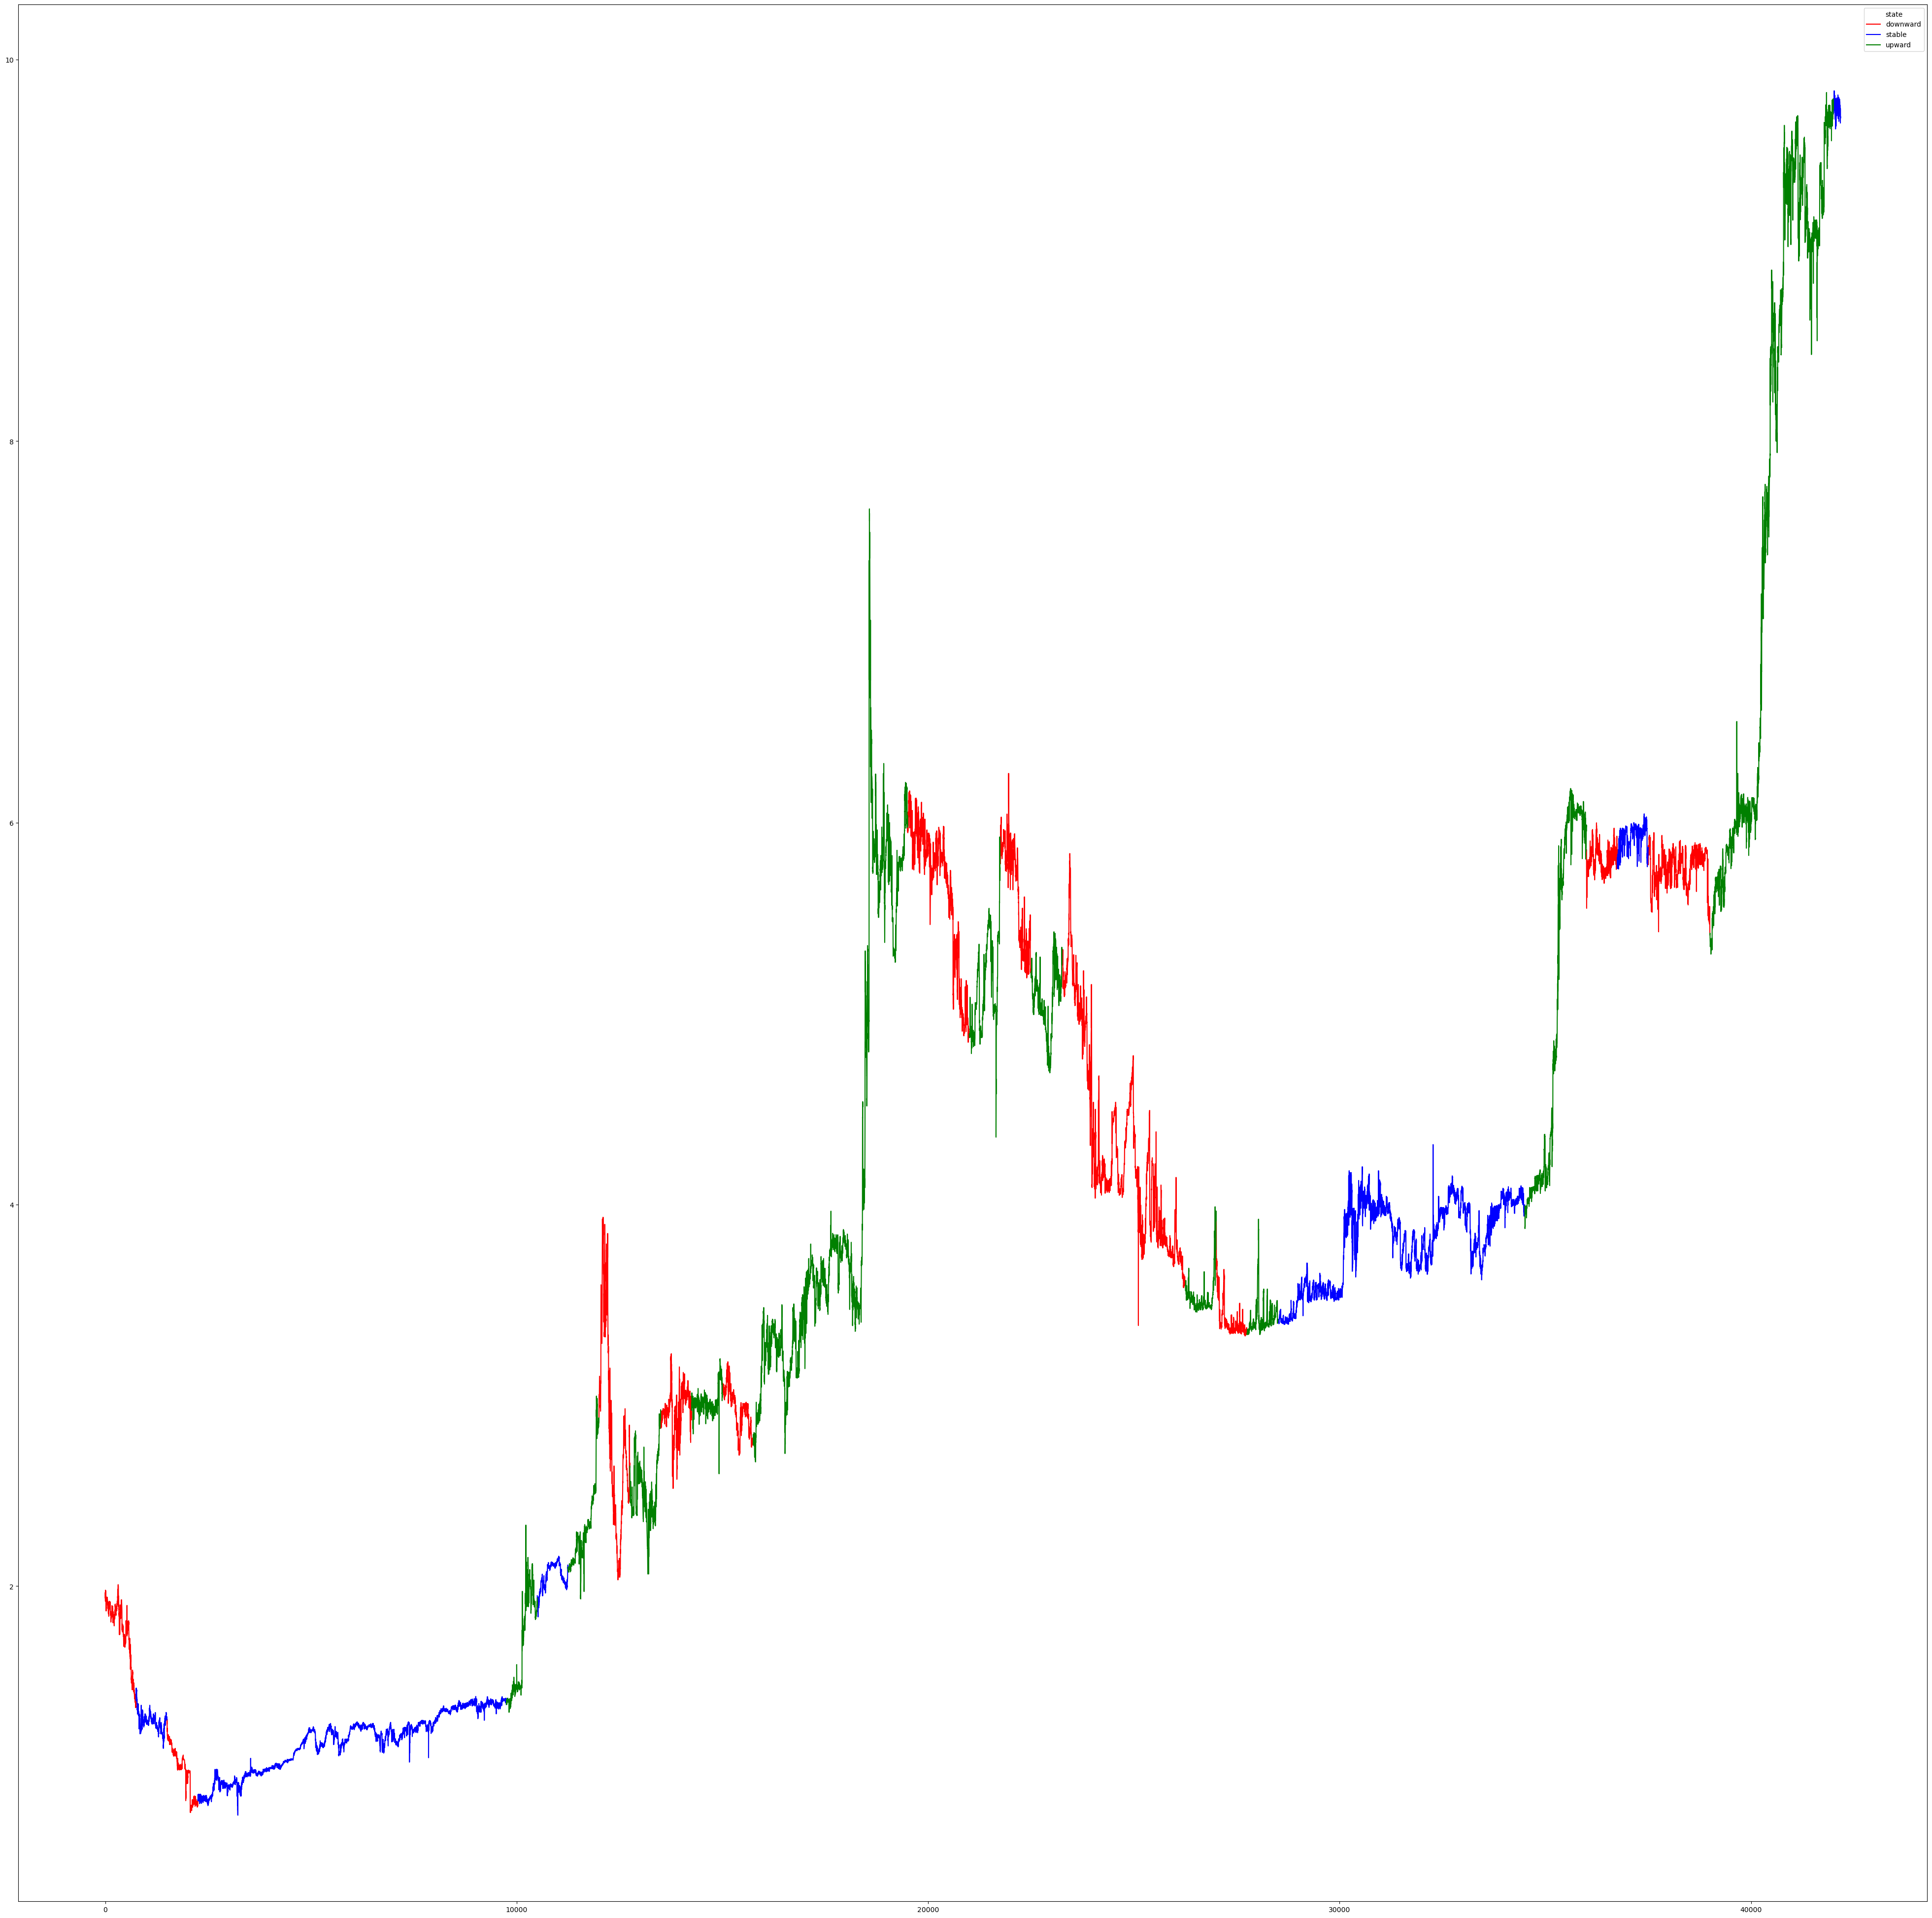

In [42]:
'''
the threshold could be re-normalized using ATR or another volatility measure (replace norm_price above), but as written it operates as a percent of mean price for stable sensitivity.Here is your requested modification, ensuring that a chain of alternating 'upward'/'downward' regions is only relabeled as 'stable' if every local minimum is within the threshold of its immediate neighbors (preceding and subsequent minima), and likewise for maxima. Minimum/maximum pairs are only compared to other minima/maxima (not across).

The up/down amplitude is ignored: only the spread of neighboring minima and neighboring maxima in the sequence are checked.
'''
def label_market_states_stable_priority_nearest_extrema_renormalized(
    df,
    price_col='close',
    atr_window=30,
    ma_window=50,
    min_extrema_order=10,
    max_extrema_order=30,
    regression_window=30,
    threshold_factor=1.25,
    tol=0.25,
    dbscan_eps=0.5,
    dbscan_min_samples=2,
    trend_p=0.05,
    extrema_similarity_thresh=0.05  # % of mean price
):
    # ... Preprocessing and initial labeling omitted: states[] must be filled properly first!
    # Existing states assignment logic here (as before) ...
    # --- states = np.full(n, np.nan, dtype=object) ... your logic --- #

    # Example placeholder logic -- replace with your real labeling logic
    prices = pd.to_numeric(df[price_col], errors='coerce').fillna(method='ffill').values
    n = len(prices)
    states = np.full(n, np.nan, dtype=object)
    regression_window = min(regression_window, len(prices))
    for i in range(0, n, regression_window):
        if np.ptp(prices[i:i+regression_window]) < np.mean(prices) * threshold_factor * 0.03:
            states[i:i+regression_window] = 'stable'
        else:
            if prices[i] <= prices[min(i+regression_window-1, n-1)]:
                states[i:i+regression_window] = 'upward'
            else:
                states[i:i+regression_window] = 'downward'

    # --------- New post-processing logic ---------------
    # 1. Find segment runs of same label
    segments = []
    start = 0
    for i in range(1, n):
        if states[i] != states[start]:
            segments.append({'start': start, 'end': i-1, 'label': states[start]})
            start = i
    segments.append({'start': start, 'end': n-1, 'label': states[start]})

    # 2. Sweep through up/down chain
    new_states = states.copy()
    i = 0
    while i < len(segments):
        if segments[i]['label'] not in ('upward','downward'):
            i += 1
            continue
        # Collect consecutive updown segments
        chain_mins, chain_maxs, chain_mini, chain_maxi, segidx = [], [], [], [], []
        j = i
        while j < len(segments) and segments[j]['label'] in ('upward','downward'):
            seg = segments[j]
            seg_px = prices[seg['start']:seg['end']+1]
            if seg['label']=='upward':
                chain_mins.append(seg_px[0])
                chain_mini.append(seg['start'])
                chain_maxs.append(seg_px[-1])
                chain_maxi.append(seg['end'])
            else:
                chain_maxs.append(seg_px[0])
                chain_maxi.append(seg['start'])
                chain_mins.append(seg_px[-1])
                chain_mini.append(seg['end'])
            segidx.append(j)
            j += 1
        # If more than one region
        if len(chain_mins)>1 and len(chain_maxs)>1:
            mp = np.mean(prices[segments[i]['start']:segments[j-1]['end']+1])
            # Check all consecutive minima/minima and maxima/maxima differences
            min_condition = all(abs(chain_mins[k]-chain_mins[k+1]) <= extrema_similarity_thresh*mp for k in range(len(chain_mins)-1))
            max_condition = all(abs(chain_maxs[k]-chain_maxs[k+1]) <= extrema_similarity_thresh*mp for k in range(len(chain_maxs)-1))
            if min_condition and max_condition:
                new_states[segments[i]['start']:segments[j-1]['end']+1] = 'stable'
        i = j

    df['state'] = new_states
    return df

# Example usage (assume df is OHLC, 'close' is price, etc.):
#df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv', skip_blank_lines=True)
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')

df = dfleo.copy()


df['close'] = pd.to_numeric(df['close'], errors='coerce')
df = label_market_states_stable_priority_nearest_extrema_renormalized(
    df,
    price_col='close',
    atr_window=100,          #10 ATR reacts quickly to current high vol
    ma_window=100,           #10 Short MA, tracks mean closely in choppy conditions
    min_extrema_order=50,    #3 Capture frequent local swings (minimum allowed)
    max_extrema_order=300,   #30 Detect all scales of choppiness
    regression_window=750,    #20 Short, so labels react fast
    threshold_factor=3.0,   #3.0 ALLOW very wide range for 'stable': 3x ATR. THIS ONE SEEMS MOST IMPORTANT
    tol=0.75,               #0.75 *Very tolerant* of up/down movement inside segment (labels more as stable!)
    dbscan_eps=1.5,         #1.5 Cluster peaks/valleys broadly for fuzzy similarity SEEMS LESS IMPACT
    dbscan_min_samples=2,   #2 Minimum for cluster, default is good
    trend_p=0.2,             #0.2 Less strict about rejecting slope as random (so up/down less often assigned) SEEMS LESS IMPACT
    extrema_similarity_thresh=0.15) #0.15)

'''
ORIGINAL, high tolerance for flat, good mix of flat, preference for trending
    df,
    price_col='close',
    atr_window=30,30,30
    ma_window=50,50,50
    min_extrema_order=10,10,10
    max_extrema_order=30,30,30
    regression_window=30,50,50
    threshold_factor=1.25,1.5,0.5
    tol=0.25,0.5,0.3
    dbscan_eps=0.5,0.5,0.5
    dbscan_min_samples=2,2,5
    trend_p=0.05,0.5,0.5
    extrema_similarity_thresh=0.05,0.15,0.1  # % of mean price
):

'''

'''
df = label_market_states_stable_priority(
    df,
    price_col='close',
    atr_window=10,          # ATR reacts quickly to current high vol
    ma_window=10,           # Short MA, tracks mean closely in choppy conditions
    min_extrema_order=3,    # Capture frequent local swings (minimum allowed)
    max_extrema_order=10,   # Detect all scales of choppiness
    regression_window=8,    # Short, so labels react fast
    threshold_factor=3.0,   # ALLOW very wide range for 'stable': 3x ATR
    tol=0.75,               # *Very tolerant* of up/down movement inside segment (labels more as stable!)
    dbscan_eps=1.0,         # Cluster peaks/valleys broadly for fuzzy similarity
    dbscan_min_samples=2,   # Minimum for cluster, default is good
    trend_p=0.2             # Less strict about rejecting slope as random (so up/down less often assigned)
)



Arg Name	Type	For Sensitivity	Why	Range (for max sensitivity)
threshold_factor	float	Increase	Allows stable in high vol	2.0 to 3.0
volatility_factor	float	Increase	Same as above	2.0 to 3.0
stable_mult	float	Increase	Permits wider stable swing	2.0 to 3.0
tol	float	Increase	Lets small trends count as stable	0.5 to 0.75
min_run	int	Decrease	Shorter ranges counted	3 to 8
atr_window	int	Decrease	ATR adapts fast to new vol	5 to 10
'''

graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

<AxesSubplot:>

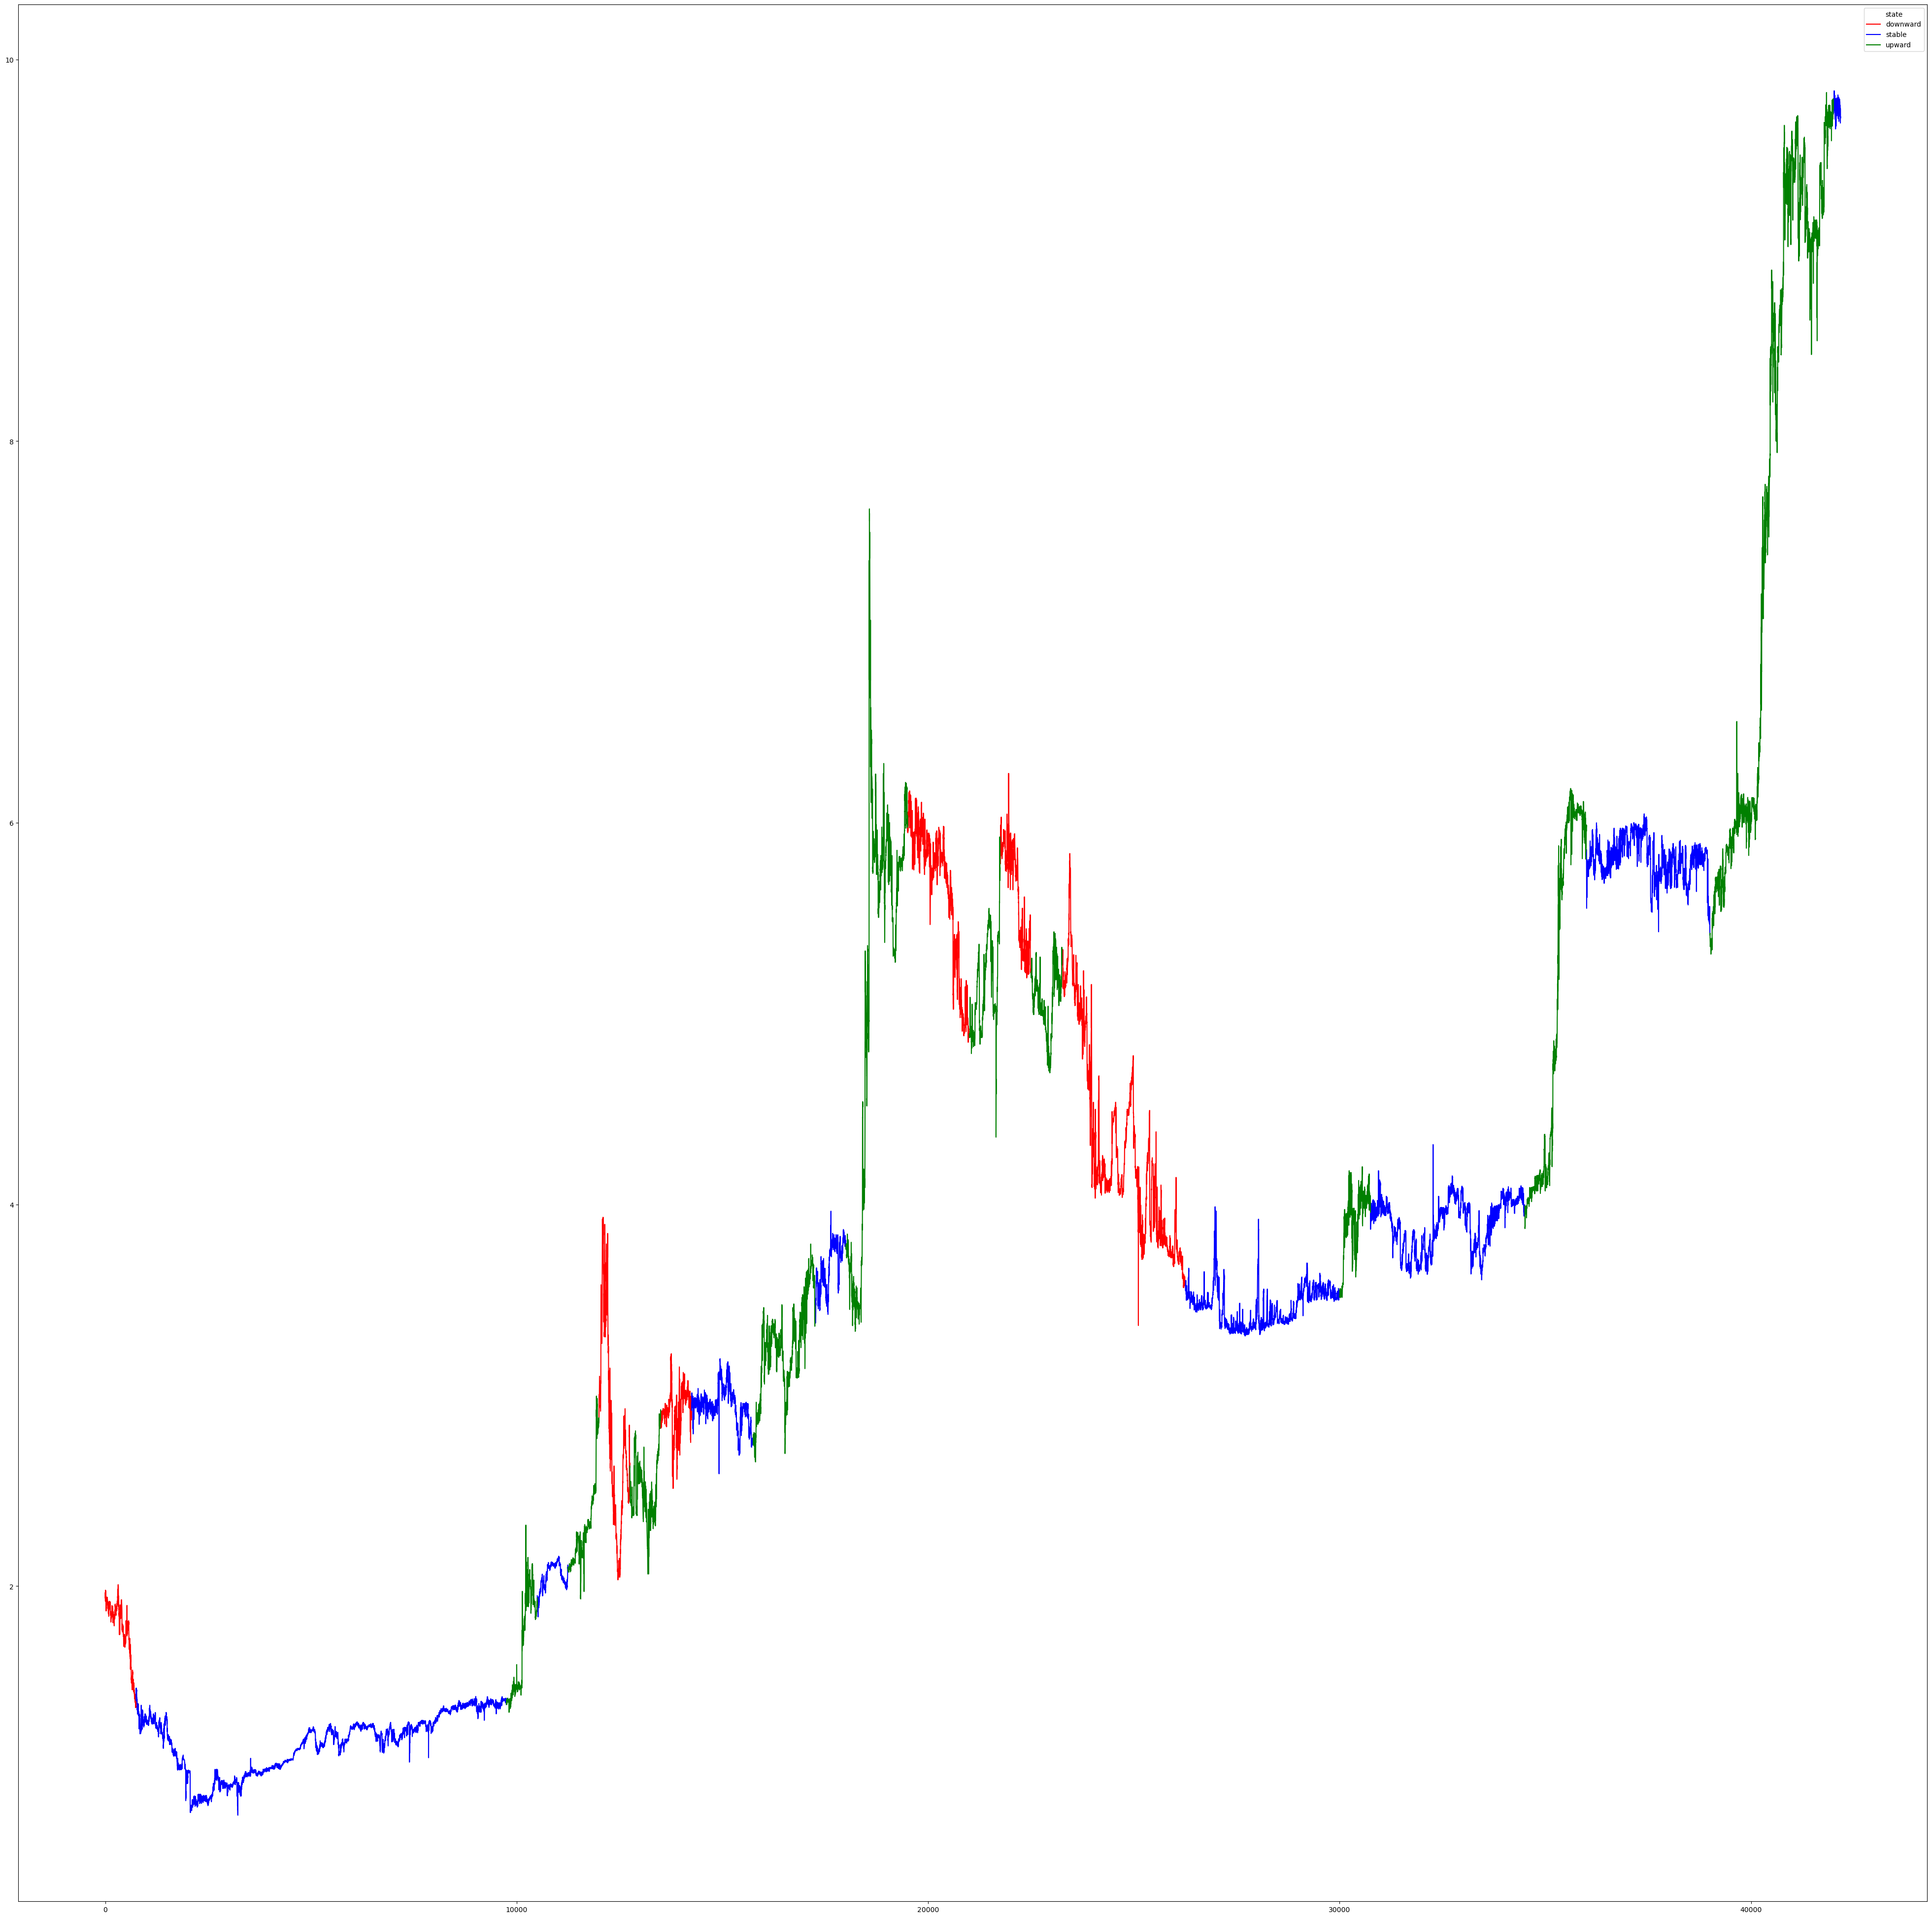

In [50]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from scipy.stats import linregress
from sklearn.cluster import DBSCAN

def label_market_states_stable_priority(
    df,
    price_col='close',
    atr_window=30,
    ma_window=50,
    min_extrema_order=10,
    max_extrema_order=30,
    regression_window=30,
    threshold_factor=1.25,
    tol=0.25,
    dbscan_eps=0.5,
    dbscan_min_samples=2,
    trend_p=0.05,
    extrema_similarity_thresh=0.05
):
    df = df.copy()
    prices = pd.to_numeric(df[price_col], errors='coerce').fillna(method='ffill').values
    n = len(prices)

    # Technical indicators
    df['prev_close'] = df[price_col].shift(1)
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.abs(df['high'] - df['prev_close']),
        np.abs(df['low'] - df['prev_close'])
    )
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    df['MA'] = df[price_col].rolling(ma_window).mean()
    df['threshold'] = threshold_factor * df['ATR']
    recent_vol = pd.Series(prices).rolling(window=atr_window, min_periods=10).std().fillna(method='bfill').values

    states = np.full(n, np.nan, dtype=object)

    # Windowed labeling (stable first as priority)
    for i in range(n - regression_window):
        window = slice(i, i + regression_window)
        window_prices = prices[window]
        window_ma = df['MA'].iloc[window].values
        window_atr = df['ATR'].iloc[i]
        window_thresh = df['threshold'].iloc[i]

        # Extrema/fuzzy features (ds_script2/ds_script3)
        minima = argrelextrema(window_prices, np.less, order=3)[0]
        maxima = argrelextrema(window_prices, np.greater, order=3)[0]
        min_diff = np.std(window_prices[minima])/(window_atr+1e-8) if len(minima) > 1 else 0
        max_diff = np.std(window_prices[maxima])/(window_atr+1e-8) if len(maxima) > 1 else 0
        ma_crosses = len(np.where(np.diff(np.sign(window_prices - window_ma)))[0])
        ma_flat = False
        try:
            slope_ma, _, _, ma_pvalue, _ = linregress(np.arange(ma_window), df['MA'].iloc[i:i+ma_window])
            ma_flat = (abs(slope_ma) < (window_atr/ma_window)) and (ma_pvalue > 0.05)
        except:
            ma_flat = False

        price_range = window_prices.max() - window_prices.min()

        # Priority: Stable condition (ds_script3 style)
        if (
            len(minima) >= 2 and len(maxima) >= 2 and
            min_diff < 0.5 and max_diff < 0.5 and
            ma_crosses >= (len(minima) + len(maxima)) and
            ma_flat and price_range < window_thresh
        ):
            states[window] = 'stable'
            continue

        # Strict monotonicity (p_script style)
        diffs = np.diff(window_prices)
        if (window_prices[0] == np.min(window_prices)) and (window_prices[-1] == np.max(window_prices)):
            pct_up = np.sum(diffs > 0) / (regression_window - 1)
            if pct_up >= (1 - tol):
                states[window] = 'upward'
                continue
        if (window_prices[0] == np.max(window_prices)) and (window_prices[-1] == np.min(window_prices)):
            pct_down = np.sum(diffs < 0) / (regression_window - 1)
            if pct_down >= (1 - tol):
                states[window] = 'downward'
                continue

        # Regression slope and p-value (ds_script3)
        x = np.arange(regression_window)
        slope, _, _, p_value, _ = linregress(x, window_prices)
        slope_thr = window_atr / regression_window if not np.isnan(window_atr) else np.std(window_prices) / regression_window
        if slope > slope_thr and p_value < trend_p:
            states[window] = 'upward'
            continue
        elif slope < -slope_thr and p_value < trend_p:
            states[window] = 'downward'
            continue

    # Fuzzy DBSCAN clustering for fuzzy extrema labeling (ds_script2)
    extrema_idx = set()
    for order in range(min_extrema_order, max_extrema_order + 1):
        min_idx = argrelextrema(prices, np.less_equal, order=order)[0]
        max_idx = argrelextrema(prices, np.greater_equal, order=order)[0]
        extrema_idx.update(min_idx)
        extrema_idx.update(max_idx)
    extrema_idx = np.array(sorted(list(extrema_idx)))
    if len(extrema_idx) >= 2:
        levels = prices[extrema_idx].reshape(-1, 1)
        clusters = DBSCAN(eps=dbscan_eps * np.std(prices), min_samples=dbscan_min_samples).fit_predict(levels)
        for ci in np.unique(clusters):
            mask = clusters == ci
            member_idx = extrema_idx[mask]
            mmin, mmax = prices[member_idx].min(), prices[member_idx].max()
            for idx in member_idx:
                if np.abs(prices[idx] - mmin) < 1e-8 and pd.isna(states[idx]):
                    states[idx] = 'downward'
                elif np.abs(prices[idx] - mmax) < 1e-8 and pd.isna(states[idx]):
                    states[idx] = 'upward'

    # Fill gaps with stable if range is low relative to ATR/threshold
    for i in range(n):
        if pd.isna(states[i]):
            lookback = min(regression_window, i)
            lookahead = min(regression_window, n - i - 1)
            window_prices = prices[i - lookback:i + lookahead + 1]
            if len(window_prices) > 1 and (window_prices.max() - window_prices.min()) < df['threshold'].iloc[i]:
                states[i] = 'stable'
            else:
                states[i] = states[i - 1] if i > 0 else 'stable'

    # --- Post-processing: Relabel up/down chains as 'stable' if neighbor extrema are close
    segments = []
    start = 0
    for i in range(1, n):
        if states[i] != states[start]:
            segments.append({'start': start, 'end': i - 1, 'label': states[start]})
            start = i
    segments.append({'start': start, 'end': n - 1, 'label': states[start]})

    new_states = states.copy()
    i = 0
    while i < len(segments):
        if segments[i]['label'] not in ('upward', 'downward'):
            i += 1
            continue
        chain_mins, chain_maxs = [], []
        j = i
        while j < len(segments) and segments[j]['label'] in ('upward', 'downward'):
            seg = segments[j]
            seg_px = prices[seg['start']:seg['end'] + 1]
            if seg['label'] == 'upward':
                chain_mins.append(seg_px[0])
                chain_maxs.append(seg_px[-1])
            else:
                chain_maxs.append(seg_px[0])
                chain_mins.append(seg_px[-1])
            j += 1
        if len(chain_mins) > 1 and len(chain_maxs) > 1:
            mean_price = np.mean(prices[segments[i]['start']:segments[j - 1]['end'] + 1])
            min_condition = all(
                abs(chain_mins[k] - chain_mins[k + 1]) <= extrema_similarity_thresh * mean_price for k in range(len(chain_mins) - 1))
            max_condition = all(
                abs(chain_maxs[k] - chain_maxs[k + 1]) <= extrema_similarity_thresh * mean_price for k in range(len(chain_maxs) - 1))
            if min_condition and max_condition:
                rng = range(segments[i]['start'], segments[j - 1]['end'] + 1)
                new_states[rng] = 'stable'
        i = j

    df['state'] = new_states
    return df


#run
df = dfleo.copy()


df['close'] = pd.to_numeric(df['close'], errors='coerce')
df = label_market_states_stable_priority_nearest_extrema_renormalized(
    df,
    price_col='close',
    atr_window=100,          #10 ATR reacts quickly to current high vol
    ma_window=100,           #10 Short MA, tracks mean closely in choppy conditions
    min_extrema_order=200,    #3 Capture frequent local swings (minimum allowed)
    max_extrema_order=200,   #30 Detect all scales of choppiness
    regression_window=750,    #20 Short, so labels react fast
    threshold_factor=5.5,   #3.0 ALLOW very wide range for 'stable': 3x ATR. THIS ONE SEEMS MOST IMPORTANT
    tol=0.75,               #0.75 *Very tolerant* of up/down movement inside segment (labels more as stable!)
    dbscan_eps=1.5,         #1.5 Cluster peaks/valleys broadly for fuzzy similarity SEEMS LESS IMPACT
    dbscan_min_samples=2,   #2 Minimum for cluster, default is good
    trend_p=0.2,             #0.2 Less strict about rejecting slope as random (so up/down less often assigned) SEEMS LESS IMPACT
    extrema_similarity_thresh=0.15) #0.15)

#grpah

graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)


<AxesSubplot:>

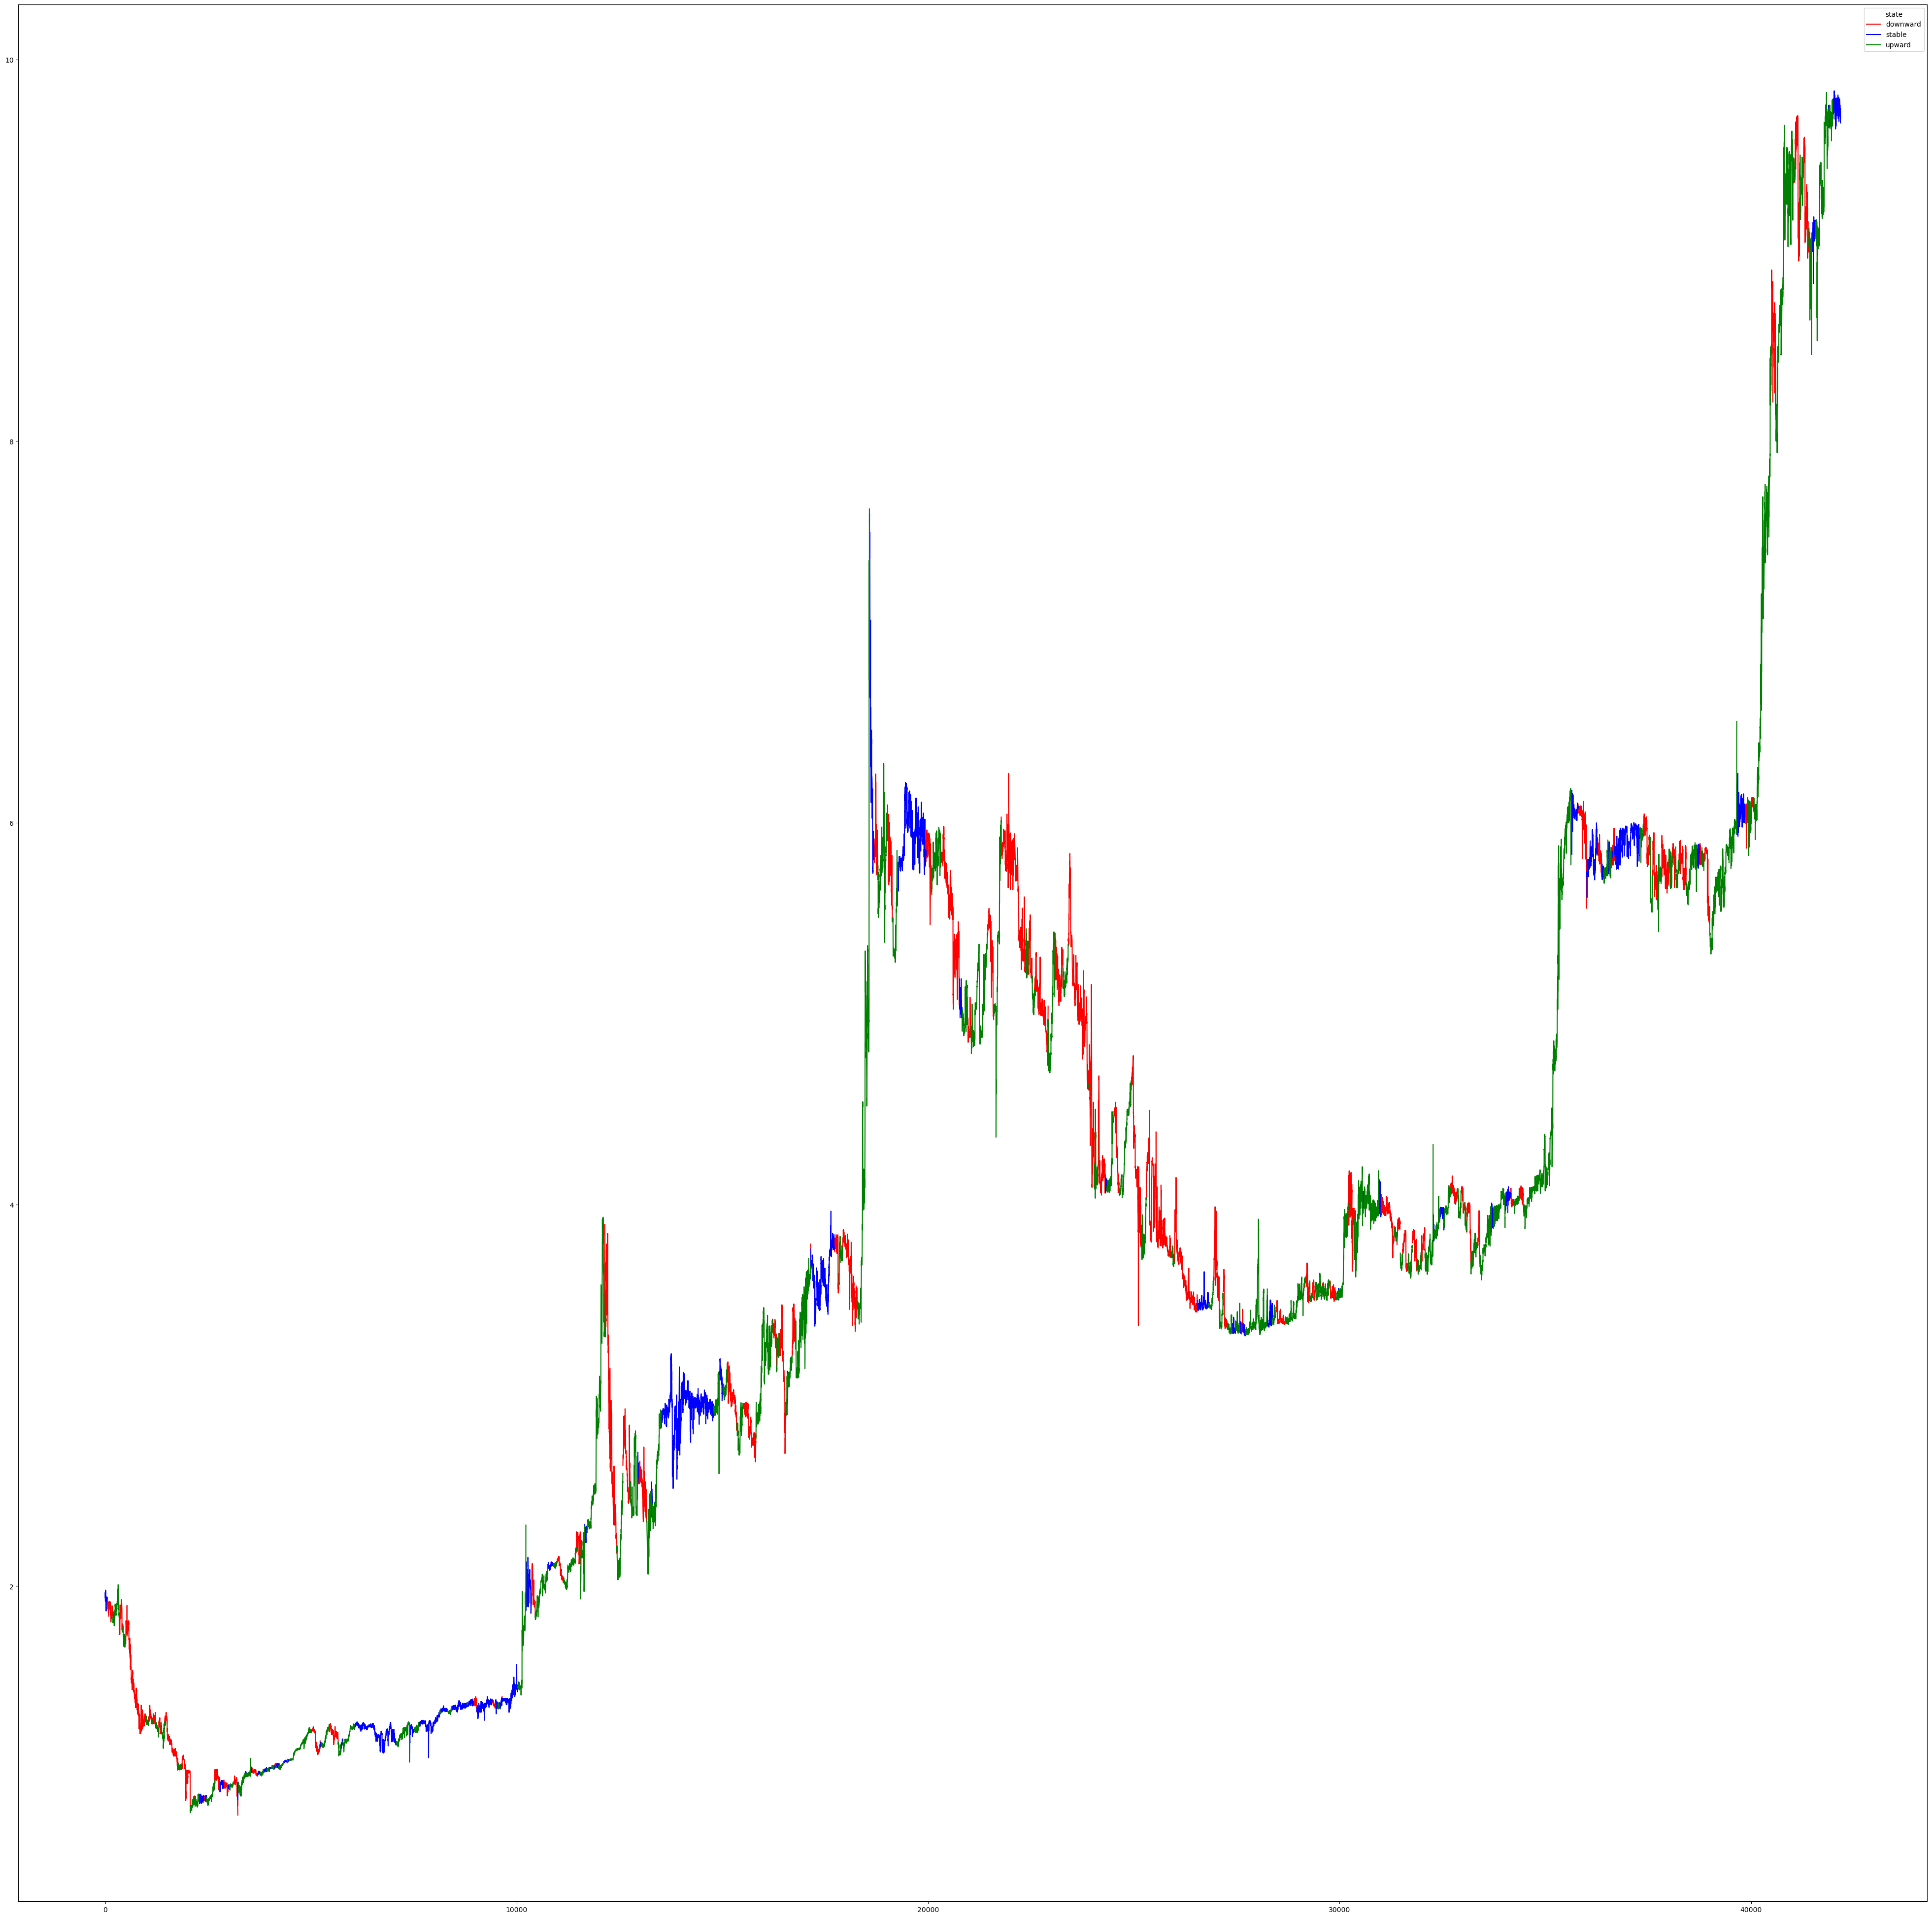

In [59]:
#function here
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from scipy.stats import linregress
from sklearn.cluster import DBSCAN

def label_market_states_stable_priority(
    df,
    price_col='close',
    atr_window=30,
    ma_window=50,
    min_extrema_order=10,
    max_extrema_order=30,
    regression_window=30,
    threshold_factor=1.25,
    tol=0.25,
    dbscan_eps=0.5,
    dbscan_min_samples=2,
    trend_p=0.05,
    extrema_similarity_thresh=0.05
):
    df = df.copy()
    prices = pd.to_numeric(df[price_col], errors='coerce').fillna(method='ffill').values
    n = len(prices)

    # Technical indicators
    df['prev_close'] = df[price_col].shift(1)
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.abs(df['high'] - df['prev_close']),
        np.abs(df['low'] - df['prev_close'])
    )
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    df['MA'] = df[price_col].rolling(ma_window).mean()
    df['threshold'] = threshold_factor * df['ATR']
    recent_vol = pd.Series(prices).rolling(window=atr_window, min_periods=10).std().fillna(method='bfill').values

    states = np.full(n, np.nan, dtype=object)

    # --- Windowed labeling with strict extremum start/end
    for i in range(n - regression_window):
        window = slice(i, i + regression_window)
        window_prices = prices[window]
        window_ma = df['MA'].iloc[window].values
        window_atr = df['ATR'].iloc[i]
        window_thresh = df['threshold'].iloc[i]

        minima = argrelextrema(window_prices, np.less, order=3)[0]
        maxima = argrelextrema(window_prices, np.greater, order=3)[0]
        min_diff = np.std(window_prices[minima])/(window_atr+1e-8) if len(minima) > 1 else 0
        max_diff = np.std(window_prices[maxima])/(window_atr+1e-8) if len(maxima) > 1 else 0
        ma_crosses = len(np.where(np.diff(np.sign(window_prices - window_ma)))[0])
        ma_flat = False
        try:
            slope_ma, _, _, ma_pvalue, _ = linregress(np.arange(ma_window), df['MA'].iloc[i:i+ma_window])
            ma_flat = (abs(slope_ma) < (window_atr/ma_window)) and (ma_pvalue > 0.05)
        except:
            ma_flat = False

        price_range = window_prices.max() - window_prices.min()

        # Priority: Stable
        if (
            len(minima) >= 2 and len(maxima) >= 2 and
            min_diff < 0.5 and max_diff < 0.5 and
            ma_crosses >= (len(minima) + len(maxima)) and
            ma_flat and price_range < window_thresh
        ):
            states[window] = 'stable'
            continue

        # Strict upward: must start at min, end at max, and no earlier price exceeds final price in this upward segment
        if (window_prices[0] == np.min(window_prices)) and (window_prices[-1] == np.max(window_prices)):
            if np.all(window_prices[:-1] <= window_prices[-1]):
                pct_up = np.sum(np.diff(window_prices) > 0) / (regression_window - 1)
                if pct_up >= (1 - tol):
                    states[window] = 'upward'
                    continue
        # Strict downward: must start at max, end at min, and no earlier price less than the final price in this downward segment
        if (window_prices[0] == np.max(window_prices)) and (window_prices[-1] == np.min(window_prices)):
            if np.all(window_prices[:-1] >= window_prices[-1]):
                pct_down = np.sum(np.diff(window_prices) < 0) / (regression_window - 1)
                if pct_down >= (1 - tol):
                    states[window] = 'downward'
                    continue

        # Regression slope and p-value
        x = np.arange(regression_window)
        slope, _, _, p_value, _ = linregress(x, window_prices)
        slope_thr = window_atr / regression_window if not np.isnan(window_atr) else np.std(window_prices) / regression_window
        if slope > slope_thr and p_value < trend_p:
            # EXTREMUM ENFORCEMENT: Only assign upward if it terminates at a true local max (no earlier higher price in this upward run)
            if window_prices[-1] == np.max(window_prices) and np.all(window_prices[:-1] <= window_prices[-1]):
                states[window] = 'upward'
                continue
        elif slope < -slope_thr and p_value < trend_p:
            if window_prices[-1] == np.min(window_prices) and np.all(window_prices[:-1] >= window_prices[-1]):
                states[window] = 'downward'
                continue

    # Fuzzy DBSCAN clustering for extrema/state clean up
    extrema_idx = set()
    for order in range(min_extrema_order, max_extrema_order + 1):
        min_idx = argrelextrema(prices, np.less_equal, order=order)[0]
        max_idx = argrelextrema(prices, np.greater_equal, order=order)[0]
        extrema_idx.update(min_idx)
        extrema_idx.update(max_idx)
    extrema_idx = np.array(sorted(list(extrema_idx)))
    if len(extrema_idx) >= 2:
        levels = prices[extrema_idx].reshape(-1, 1)
        clusters = DBSCAN(eps=dbscan_eps * np.std(prices), min_samples=dbscan_min_samples).fit_predict(levels)
        for ci in np.unique(clusters):
            mask = clusters == ci
            member_idx = extrema_idx[mask]
            mmin, mmax = prices[member_idx].min(), prices[member_idx].max()
            for idx in member_idx:
                # Extremum-based enforcement: do not override strict logic!
                if np.abs(prices[idx] - mmin) < 1e-8 and pd.isna(states[idx]):
                    states[idx] = 'downward'
                elif np.abs(prices[idx] - mmax) < 1e-8 and pd.isna(states[idx]):
                    states[idx] = 'upward'

    # Fill gaps with stable where price range is low
    for i in range(n):
        if pd.isna(states[i]):
            lookback = min(regression_window, i)
            lookahead = min(regression_window, n - i - 1)
            window_prices = prices[i - lookback:i + lookahead + 1]
            if len(window_prices) > 1 and (window_prices.max() - window_prices.min()) < df['threshold'].iloc[i]:
                states[i] = 'stable'
            else:
                states[i] = states[i - 1] if i > 0 else 'stable'

    # --- Post-processing: Relabel up/down chains as 'stable' if neighbor extrema are close
    segments = []
    start = 0
    for i in range(1, n):
        if states[i] != states[start]:
            segments.append({'start': start, 'end': i - 1, 'label': states[start]})
            start = i
    segments.append({'start': start, 'end': n - 1, 'label': states[start]})

    new_states = states.copy()
    i = 0
    while i < len(segments):
        if segments[i]['label'] not in ('upward', 'downward'):
            i += 1
            continue
        chain_mins, chain_maxs = [], []
        j = i
        while j < len(segments) and segments[j]['label'] in ('upward', 'downward'):
            seg = segments[j]
            seg_px = prices[seg['start']:seg['end'] + 1]
            if seg['label'] == 'upward':
                chain_mins.append(seg_px[0])
                chain_maxs.append(seg_px[-1])
            else:
                chain_maxs.append(seg_px[0])
                chain_mins.append(seg_px[-1])
            j += 1
        if len(chain_mins) > 1 and len(chain_maxs) > 1:
            mean_price = np.mean(prices[segments[i]['start']:segments[j - 1]['end'] + 1])
            min_condition = all(
                abs(chain_mins[k] - chain_mins[k + 1]) <= extrema_similarity_thresh * mean_price for k in range(len(chain_mins) - 1))
            max_condition = all(
                abs(chain_maxs[k] - chain_maxs[k + 1]) <= extrema_similarity_thresh * mean_price for k in range(len(chain_maxs) - 1))
            if min_condition and max_condition:
                rng = range(segments[i]['start'], segments[j - 1]['end'] + 1)
                new_states[rng] = 'stable'
        i = j

    df['state'] = new_states
    return df

# Example usage:
# df = pd.read_csv('your_ohlc_data.csv')
# df = label_market_states_stable_priority(
#     df,
#     price_col='close',
#     atr_window=10, ma_window=10, min_extrema_order=3, max_extrema_order=10,
#     regression_window=8, threshold_factor=3.0, tol=0.75, dbscan_eps=1.0, dbscan_min_samples=2, trend_p=0.2,
#     extrema_similarity_thresh=0.05
# )
# print(df[['timestamp', 'close', 'state']])



#run
df = dfleo.copy()
#label_market_states_stable_priority

df['close'] = pd.to_numeric(df['close'], errors='coerce')
df = label_market_states_stable_priority(
     df,
     price_col='close',
     atr_window=10, ma_window=10, min_extrema_order=3, max_extrema_order=10,
     regression_window=100, threshold_factor=3.0, tol=0.75, dbscan_eps=1.0, dbscan_min_samples=2, trend_p=0.2,
     extrema_similarity_thresh=0.05
 )
'''    
df = label_market_states_stable_priority(
    df,
    price_col='close',
    atr_window=100,          #10 ATR reacts quickly to current high vol
    ma_window=100,           #10 Short MA, tracks mean closely in choppy conditions
    min_extrema_order=200,    #3 Capture frequent local swings (minimum allowed)
    max_extrema_order=200,   #30 Detect all scales of choppiness
    regression_window=750,    #20 Short, so labels react fast
    threshold_factor=5.5,   #3.0 ALLOW very wide range for 'stable': 3x ATR. THIS ONE SEEMS MOST IMPORTANT
    tol=0.75,               #0.75 *Very tolerant* of up/down movement inside segment (labels more as stable!)
    dbscan_eps=1.5,         #1.5 Cluster peaks/valleys broadly for fuzzy similarity SEEMS LESS IMPACT
    dbscan_min_samples=2,   #2 Minimum for cluster, default is good
    trend_p=0.2,             #0.2 Less strict about rejecting slope as random (so up/down less often assigned) SEEMS LESS IMPACT
    extrema_similarity_thresh=0.15) #0.15)
'''
#graph

graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)


In [ ]:
'''
SAVED

good for Leo, 1h. could use a little more rangebound state sensitivity
df = label_market_states_stable_priority(
     df,
     price_col='close',
     atr_window=10, ma_window=10, min_extrema_order=3, max_extrema_order=10,
     regression_window=100, threshold_factor=3.0, tol=0.75, dbscan_eps=1.0, dbscan_min_samples=2, trend_p=0.2,
     extrema_similarity_thresh=0.05
 )
 
 


'''

<AxesSubplot:>

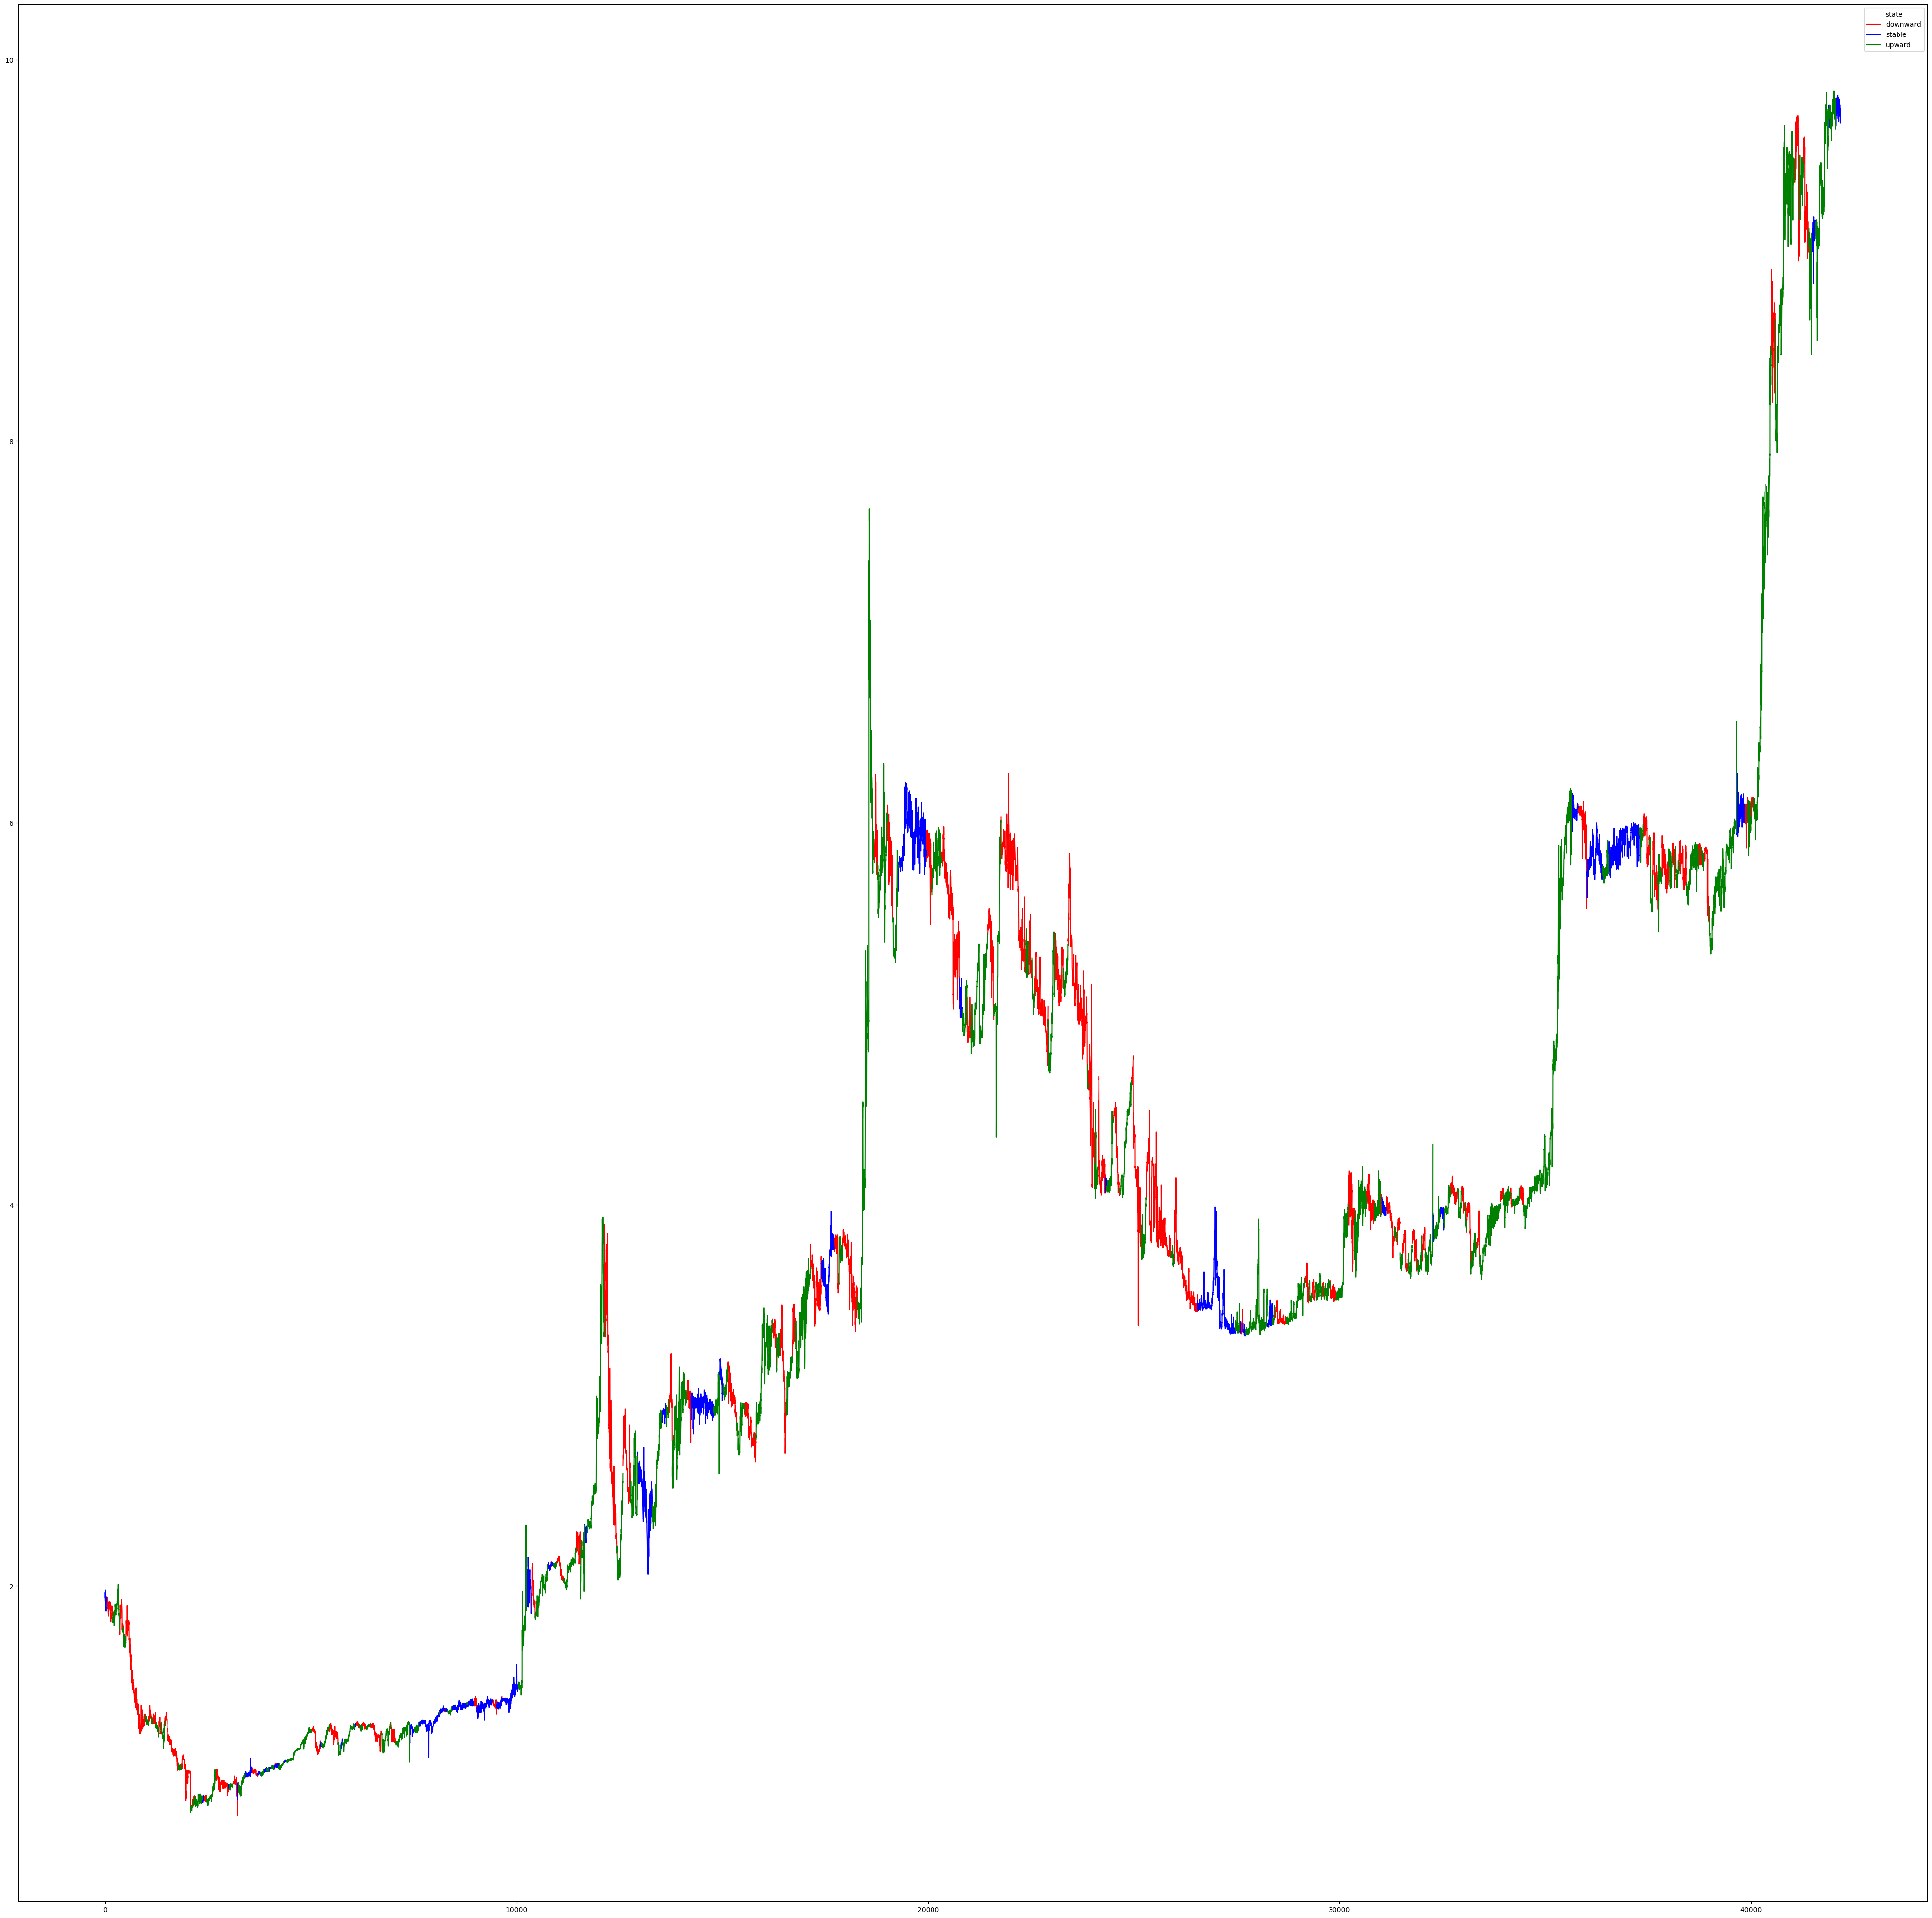

In [61]:
#run
#dfbtc = 
#dfdog = 
#dfleo = 
#dfxrp = 
df = dfleo.copy()
#df = dfbtc.copy()
#df = dfdog.copy()
#df = dfxrp.copy()
#label_market_states_stable_priority

df['close'] = pd.to_numeric(df['close'], errors='coerce')
df = label_market_states_stable_priority(
     df,
     price_col='close',
     atr_window=15, ma_window=10, min_extrema_order=3, max_extrema_order=10,
     regression_window=100, threshold_factor=3.0, tol=0.75, dbscan_eps=1.0, dbscan_min_samples=2, trend_p=0.2,
     extrema_similarity_thresh=0.05
 )
'''    
df = label_market_states_stable_priority(
    df,
    price_col='close',
    atr_window=100,          #10 ATR reacts quickly to current high vol
    ma_window=100,           #10 Short MA, tracks mean closely in choppy conditions
    min_extrema_order=200,    #3 Capture frequent local swings (minimum allowed)
    max_extrema_order=200,   #30 Detect all scales of choppiness
    regression_window=750,    #20 Short, so labels react fast
    threshold_factor=5.5,   #3.0 ALLOW very wide range for 'stable': 3x ATR. THIS ONE SEEMS MOST IMPORTANT
    tol=0.75,               #0.75 *Very tolerant* of up/down movement inside segment (labels more as stable!)
    dbscan_eps=1.5,         #1.5 Cluster peaks/valleys broadly for fuzzy similarity SEEMS LESS IMPACT
    dbscan_min_samples=2,   #2 Minimum for cluster, default is good
    trend_p=0.2,             #0.2 Less strict about rejecting slope as random (so up/down less often assigned) SEEMS LESS IMPACT
    extrema_similarity_thresh=0.15) #0.15)
'''
#graph

graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)